In [82]:
import numpy as np
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from utilities import dLambda
from solver_1d import false_transient_one_iteration_python
import global_parameters as gp
from supportfunctions import finiteDiff
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d
import time
import SolveLinSys
import time
from supportfunctions import PDESolver_2d, finiteDiff
import global_parameters as gp
from utilities import dLambda, ddLambda, weightOfPi, relativeEntropy, weightPI, damageDrift, zDrift

In [2]:
@njit
def derivative_1d(data, order, h_data, upwind=True):
    num, = data.shape
    ddata = np.zeros_like(data)
    if order == 1:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+1]-data[i])/h_data
            elif i == num-1:
                ddata[i] = (data[i]-data[i-1])/h_data
            else: 
                if upwind == True:
                    ddata[i] = (data[i]-data[i-1])/h_data
                else:
                    ddata[i] = (data[i+1]-data[i-1])/(2*h_data)
    elif order == 2:
        for i in range(num):
            if i == 0:
                ddata[i] = (data[i+2]-2*data[i+1] + data[i])/(h_data**2)
            elif i == num -1:
                ddata[i] = (data[i]-2*data[i-1] + data[i-2])/(h_data**2)
            else:
                ddata[i] = (data[i+1]- 2*data[i] + data[i-1])/(h_data**2)
    
    return ddata

In [3]:
@njit
def get_coeff(A, Bx, Cxx, D, x_grid, ϕ_prev, ϵ, boundspec):
    dx = x_grid[1] - x_grid[0]
    numx = len(x_grid)
    LHS = np.zeros((numx, numx))
    RHS = -1/ϵ*ϕ_prev - D
    for i in range(numx):
        LHS[i,i] += - 1/ϵ + A[i]
        if i == 0:
            LHS[i,i] += - 1/dx*Bx[i]
            LHS[i,i+1] += 1/dx*Bx[i]
        elif i == numx-1:
            if boundspec[0] == True:
                LHS[i,i] = 1
                RHS[i] = boundspec[1]
            else:
                LHS[i,i] += 1/dx*Bx[i]
                LHS[i,i-1] += -1/dx*Bx[i]
        else:
            LHS[i,i+1] += Bx[i]*(1./dx)*(Bx[i]>0) + Cxx[i]/(dx**2)
            LHS[i,i] += Bx[i]*((-1/dx)*(Bx[i]>0) + (1/dx)*(Bx[i]<0)) - 2*Cxx[i]/(dx**2)
            LHS[i,i-1] += Bx[i]*(-1/dx)*(Bx[i]<0) + Cxx[i]/(dx**2)
    return LHS, RHS

In [4]:
def solve_ode( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec):
    LHS, RHS = get_coeff( A, By, Cyy, D, y_grid, ϕ_prev, ϵ, boundspec)
    phi_grid, exit_code = bicg(csc_matrix(LHS), RHS)
#     phi_grid = np.linalg.solve(LHS, RHS)
    return phi_grid

In [5]:
def false_transient_1d(
    y_grid, z, 
    dmg_params, model_params, bounded=False, bound_var=0, 
    epsilon=0.5, tol = 1e-8, max_iter=10_000,
):
    gamma_1, gamma_2, gamma2pList, gamma_bar, dmg_weights = dmg_params
    delta, eta, mu2, sigma2, rho, v_n = model_params
    numy, = y_grid.shape
    hy = y_grid[1] - y_grid[0]
    dlambda = gamma_1 + gamma_2*y_grid\
    + np.sum(gamma2pList*dmg_weights,axis=0)*(y_grid-gamma_bar)*(y_grid>gamma_bar)
    # initiate v and control
    ems = -delta*eta/((eta-1)*dlambda*z)
    error = 1
    episode = 0
    v0 = - delta*eta*y_grid
    
    while error > tol and episode < max_iter:
        v0_old = v0.copy()
        v0_dy = derivative_1d(v0,1,hy, upwind=True)
        # control
        ems_new = -delta*eta/(v0_dy*z + v_n*dlambda*z)
        ems_new[ems_new<=0] = 1e-15
        ems = ems_new*.5 + ems*.5
        A = -delta*np.ones(y_grid.shape)
        By = z*ems
        Cyy = np.zeros(y_grid.shape)
        D = delta*eta*np.log(ems) + v_n*dlambda*z*ems
        # solve for ODE
        phi_grid = solve_ode(y_grid, A, By, Cyy, D, v0, bound_var, bounded, epsilon)
        phi_grid2 = false_transient_one_iteration_python(
            A, By, Cyy, D, v0, epsilon, hy, (0,bound_var), (False, bounded))
        diff = np.max(abs(phi_grid - phi_grid2))
        rhs = A*phi_grid + By*v0_dy + D
        rhs_error = np.max(abs(rhs))
        error = np.max(abs((phi_grid-v0)/epsilon))
        v0 = phi_grid
        episode += 1
        print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}\t diff: {:.12f}'.format(episode,error,rhs_error,diff))
    return v0, ems

In [6]:
δ = 0.01
η = 0.032
μ = 1.86/1000
ȳ = 2

numy_bar = 100
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)

γ1 = 0.00017675
γ2 = 2*0.0022
γ2p = np.array([0, 2*0.0197])
γbar = 2
dmg_weight = np.array([1, 0])
dΛ = γ1 + γ2*y_grid + np.average(γ2p, weights=dmg_weight)*(y_grid - γbar)*(y_grid>γbar)

tol = 1e-8
ϵ = .3
lhs_error = 1

In [7]:
ϕ = - δ*η*y_grid
dy = y_grid[1] - y_grid[0]
ems = -δ*η
episode = 0
while lhs_error > tol:
    ϕ_old = ϕ.copy()
    dϕdy = derivative_1d(ϕ, 1, dy, True)
    dϕdyy = derivative_1d(ϕ, 2, dy, True)
    ems = -δ*η/(dϕdy*μ + (η-1)*dΛ*μ)
    A = -δ*np.ones(y_grid.shape)
    By = μ*ems
    Cyy = np.zeros(y_grid.shape)
    D = δ*η*np.log(ems) + (η-1)*dΛ*μ*ems
    ϕ_new = solve_ode(A, By, Cyy, D, y_grid, ϕ,  ϵ, (False,0))
    rhs = A*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
    ϕ = ϕ_new
    episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

episode: 1,	 ode error: 0.0015507701573692011,	 ft error: 0.0013554655757295271
episode: 2,	 ode error: 0.0013944201792057969,	 ft error: 0.0012890766500556182
episode: 3,	 ode error: 0.001299636484308969,	 ft error: 0.0012345215390425718
episode: 4,	 ode error: 0.0012367923884590314,	 ft error: 0.0011912406605538856
episode: 5,	 ode error: 0.0011907292220521152,	 ft error: 0.001156075810254932
episode: 6,	 ode error: 0.0011544420579144624,	 ft error: 0.001126573270437606
episode: 7,	 ode error: 0.0011244139906146226,	 ft error: 0.0011011294005619525
episode: 8,	 ode error: 0.001098698555369187,	 ft error: 0.0010787079975184757
episode: 9,	 ode error: 0.0010761267737521489,	 ft error: 0.0010586228265494282
episode: 10,	 ode error: 0.0010559495177003297,	 ft error: 0.0010403707283219107
episode: 11,	 ode error: 0.001037656909618132,	 ft error: 0.001023622140226138
episode: 12,	 ode error: 0.0010208887346232292,	 ft error: 0.0010081205349473732
episode: 13,	 ode error: 0.0010053809639429

episode: 218,	 ode error: 0.0003089226165057066,	 ft error: 0.000309505745997099
episode: 219,	 ode error: 0.00030818373650792026,	 ft error: 0.00030732440635864355
episode: 220,	 ode error: 0.00030637632707684935,	 ft error: 0.00030708564277987427
episode: 221,	 ode error: 0.0003056926338274818,	 ft error: 0.0003045721944317422
episode: 222,	 ode error: 0.0003036497648028397,	 ft error: 0.0003051690447351587
episode: 223,	 ode error: 0.0003032784569872793,	 ft error: 0.00030171101589070626
episode: 224,	 ode error: 0.0003008287600530454,	 ft error: 0.00030058602830583536
episode: 225,	 ode error: 0.00029968334922664047,	 ft error: 0.00030071658080904157
episode: 226,	 ode error: 0.0002991423150062063,	 ft error: 0.00029813908683236356
episode: 227,	 ode error: 0.00029723094515775057,	 ft error: 0.00029844545194545696
episode: 228,	 ode error: 0.00029676477256320257,	 ft error: 0.0002954505983403244
episode: 229,	 ode error: 0.00029457329839891345,	 ft error: 0.00029428119530774494
epi

episode: 453,	 ode error: 0.00012049092547196068,	 ft error: 0.00012041375867138013
episode: 454,	 ode error: 0.00012003109022322878,	 ft error: 0.00011995490443901524
episode: 455,	 ode error: 0.00011957364689187708,	 ft error: 0.00011949744639180859
episode: 456,	 ode error: 0.00011911763314817036,	 ft error: 0.00011904227591015559
episode: 457,	 ode error: 0.00011866386685857307,	 ft error: 0.00011858860517464007
episode: 458,	 ode error: 0.00011821162383832899,	 ft error: 0.00011813709955656171
episode: 459,	 ode error: 0.0001177615145292241,	 ft error: 0.00011768716821120943
episode: 460,	 ode error: 0.00011731299555566628,	 ft error: 0.00011723930534846458
episode: 461,	 ode error: 0.00011686652024378596,	 ft error: 0.00011679306902705189
episode: 462,	 ode error: 0.00011642168192848884,	 ft error: 0.00011634882437450608
episode: 463,	 ode error: 0.00011597881542603993,	 ft error: 0.00011590624155517759
episode: 464,	 ode error: 0.00011553761701800719,	 ft error: 0.00011546558875

episode: 690,	 ode error: 4.969837943477411e-05,	 ft error: 4.9679089069489445e-05
episode: 691,	 ode error: 4.9515138181775676e-05,	 ft error: 4.949596700572675e-05
episode: 692,	 ode error: 4.9332578531415504e-05,	 ft error: 4.9313526058654876e-05
episode: 693,	 ode error: 4.915069789420074e-05,	 ft error: 4.9131763642124945e-05
episode: 694,	 ode error: 4.8969493691997166e-05,	 ft error: 4.8950677180789604e-05
episode: 695,	 ode error: 4.8788963357483976e-05,	 ft error: 4.8770264110288106e-05
episode: 696,	 ode error: 4.8609104334372435e-05,	 ft error: 4.8590521876899315e-05
episode: 697,	 ode error: 4.842991407691128e-05,	 ft error: 4.841144793798121e-05
episode: 698,	 ode error: 4.8251390050404216e-05,	 ft error: 4.8233039761207595e-05
episode: 699,	 ode error: 4.8073529730379826e-05,	 ft error: 4.805529482503068e-05
episode: 700,	 ode error: 4.789633060337678e-05,	 ft error: 4.787821061838042e-05
episode: 701,	 ode error: 4.7719790165954255e-05,	 ft error: 4.770178464066448e-05
e

episode: 927,	 ode error: 2.076351085644832e-05,	 ft error: 2.076265993598836e-05
episode: 928,	 ode error: 2.068738544407469e-05,	 ft error: 2.0686582106836198e-05
episode: 929,	 ode error: 2.0611540611044452e-05,	 ft error: 2.0610784676050597e-05
episode: 930,	 ode error: 2.053597531631254e-05,	 ft error: 2.053526660330633e-05
episode: 931,	 ode error: 2.046068852282299e-05,	 ft error: 2.0460026852302714e-05
episode: 932,	 ode error: 2.038567919736701e-05,	 ft error: 2.0385064390624857e-05
episode: 933,	 ode error: 2.0310946310641122e-05,	 ft error: 2.0310378189373573e-05
episode: 934,	 ode error: 2.0236488837176007e-05,	 ft error: 2.0235967224113693e-05
episode: 935,	 ode error: 2.0162305755407972e-05,	 ft error: 2.0161830473648206e-05
episode: 936,	 ode error: 2.0088396047418088e-05,	 ft error: 2.008796692089717e-05
episode: 937,	 ode error: 2.00147586992517e-05,	 ft error: 2.0014375552527646e-05
episode: 938,	 ode error: 1.9941392700776293e-05,	 ft error: 1.9941055359023095e-05
ep

episode: 1164,	 ode error: 8.710889515719752e-06,	 ft error: 8.717486424901038e-06
episode: 1165,	 ode error: 8.679087717820247e-06,	 ft error: 8.685703972698596e-06
episode: 1166,	 ode error: 8.647402540057575e-06,	 ft error: 8.654038067268388e-06
episode: 1167,	 ode error: 8.61583355228233e-06,	 ft error: 8.622488278861584e-06
episode: 1168,	 ode error: 8.58438032619313e-06,	 ft error: 8.591054179440949e-06
episode: 1169,	 ode error: 8.553042434943916e-06,	 ft error: 8.559735342426416e-06
episode: 1170,	 ode error: 8.521819453232858e-06,	 ft error: 8.52853134290325e-06
episode: 1171,	 ode error: 8.490710957473986e-06,	 ft error: 8.497441757275109e-06
episode: 1172,	 ode error: 8.459716525510523e-06,	 ft error: 8.466466164004188e-06
episode: 1173,	 ode error: 8.428835736868268e-06,	 ft error: 8.435604142593516e-06
episode: 1174,	 ode error: 8.398068172456785e-06,	 ft error: 8.404855274558403e-06
episode: 1175,	 ode error: 8.36741341508386e-06,	 ft error: 8.374219142547509e-06
episode:

episode: 1401,	 ode error: 3.6666542324203426e-06,	 ft error: 3.6762815295900606e-06
episode: 1402,	 ode error: 3.6533126086848696e-06,	 ft error: 3.6629477813641493e-06
episode: 1403,	 ode error: 3.6400196775392872e-06,	 ft error: 3.6496626959018714e-06
episode: 1404,	 ode error: 3.6267752601831533e-06,	 ft error: 3.6364260945960978e-06
episode: 1405,	 ode error: 3.613579178692386e-06,	 ft error: 3.623237799533589e-06
episode: 1406,	 ode error: 3.600431255700292e-06,	 ft error: 3.6100976335181243e-06
episode: 1407,	 ode error: 3.5873313143945304e-06,	 ft error: 3.5970054197929464e-06
episode: 1408,	 ode error: 3.5742791787396998e-06,	 ft error: 3.5839609825264835e-06
episode: 1409,	 ode error: 3.5612746733221885e-06,	 ft error: 3.5709641463497572e-06
episode: 1410,	 ode error: 3.5483176233941935e-06,	 ft error: 3.558014736610808e-06
episode: 1411,	 ode error: 3.5354078547564097e-06,	 ft error: 3.5451125792590465e-06
episode: 1412,	 ode error: 3.5225451939177328e-06,	 ft error: 3.53225

episode: 1639,	 ode error: 1.5410901197834663e-06,	 ft error: 1.5519543792215837e-06
episode: 1640,	 ode error: 1.5354898498656311e-06,	 ft error: 1.5463573032244624e-06
episode: 1641,	 ode error: 1.5299099173254112e-06,	 ft error: 1.5407805522884197e-06
episode: 1642,	 ode error: 1.524350247648844e-06,	 ft error: 1.5352240524679761e-06
episode: 1643,	 ode error: 1.518810767074186e-06,	 ft error: 1.5296877294244486e-06
episode: 1644,	 ode error: 1.513291401590653e-06,	 ft error: 1.5241715097212098e-06
episode: 1645,	 ode error: 1.5077920778309344e-06,	 ft error: 1.5186753197597251e-06
episode: 1646,	 ode error: 1.5023127226591968e-06,	 ft error: 1.5131990865428306e-06
episode: 1647,	 ode error: 1.496853263006177e-06,	 ft error: 1.5077427370271033e-06
episode: 1648,	 ode error: 1.491413626243665e-06,	 ft error: 1.5023061985160644e-06
episode: 1649,	 ode error: 1.485993739948799e-06,	 ft error: 1.4968893988914767e-06
episode: 1650,	 ode error: 1.4805935320681045e-06,	 ft error: 1.4914922

episode: 1862,	 ode error: 7.511922666905311e-07,	 ft error: 6.949800777228399e-07
episode: 1863,	 ode error: 7.536681997135893e-07,	 ft error: 6.924882795661391e-07
episode: 1864,	 ode error: 7.561351896113273e-07,	 ft error: 6.90005484022908e-07
episode: 1865,	 ode error: 7.585932691435643e-07,	 ft error: 6.87531658017752e-07
episode: 1866,	 ode error: 7.610424705159838e-07,	 ft error: 6.850667693079442e-07
episode: 1867,	 ode error: 7.634828260995015e-07,	 ft error: 6.826107850956461e-07
episode: 1868,	 ode error: 7.659143680903684e-07,	 ft error: 6.801636731843901e-07
episode: 1869,	 ode error: 7.683371283459138e-07,	 ft error: 6.7772540126206e-07
episode: 1870,	 ode error: 7.707511390749652e-07,	 ft error: 6.752959370859291e-07
episode: 1871,	 ode error: 7.731564317499601e-07,	 ft error: 6.728752488296038e-07
episode: 1872,	 ode error: 7.75553038456344e-07,	 ft error: 6.704633042503572e-07
episode: 1873,	 ode error: 7.77940990431933e-07,	 ft error: 6.680600719612592e-07
episode: 1

episode: 2080,	 ode error: 1.125420160948392e-06,	 ft error: 3.1838623929432896e-07
episode: 2081,	 ode error: 1.126547570448242e-06,	 ft error: 3.1725183269789203e-07
episode: 2082,	 ode error: 1.1276709302843841e-06,	 ft error: 3.161215019383453e-07
episode: 2083,	 ode error: 1.1287902551381087e-06,	 ft error: 3.1499523230523374e-07
episode: 2084,	 ode error: 1.1299055596008254e-06,	 ft error: 3.1387300911123184e-07
episode: 2085,	 ode error: 1.1310168581164922e-06,	 ft error: 3.1275481766901425e-07
episode: 2086,	 ode error: 1.1321241653843971e-06,	 ft error: 3.11640643522552e-07
episode: 2087,	 ode error: 1.1332274956009749e-06,	 ft error: 3.1053047193826033e-07
episode: 2088,	 ode error: 1.134326863378994e-06,	 ft error: 3.094242885757585e-07
episode: 2089,	 ode error: 1.1354222829436204e-06,	 ft error: 3.0832207897901753e-07
episode: 2090,	 ode error: 1.1365137685231648e-06,	 ft error: 3.0722382866887887e-07
episode: 2091,	 ode error: 1.1376013345208193e-06,	 ft error: 3.06129523

episode: 2312,	 ode error: 1.3032104668048161e-06,	 ft error: 1.3951017359866333e-07
episode: 2313,	 ode error: 1.3037009987899644e-06,	 ft error: 1.3901671290968606e-07
episode: 2314,	 ode error: 1.3041897800510896e-06,	 ft error: 1.3852501379770418e-07
episode: 2315,	 ode error: 1.3046768171637692e-06,	 ft error: 1.3803506990206493e-07
episode: 2316,	 ode error: 1.3051621161948735e-06,	 ft error: 1.375468748158563e-07
episode: 2317,	 ode error: 1.3056456835564825e-06,	 ft error: 1.3706042238659233e-07
episode: 2318,	 ode error: 1.306127525414237e-06,	 ft error: 1.3657570629987958e-07
episode: 2319,	 ode error: 1.3066076479387656e-06,	 ft error: 1.3609272021819496e-07
episode: 2320,	 ode error: 1.3070860573027561e-06,	 ft error: 1.3561145803531183e-07
episode: 2321,	 ode error: 1.3075627597997855e-06,	 ft error: 1.3513191343683673e-07
episode: 2322,	 ode error: 1.3080377614184445e-06,	 ft error: 1.346540803396727e-07
episode: 2323,	 ode error: 1.3085110683798851e-06,	 ft error: 1.3417

episode: 2543,	 ode error: 1.3805364215383094e-06,	 ft error: 6.173093191711813e-08
episode: 2544,	 ode error: 1.380751826806693e-06,	 ft error: 6.15142958330465e-08
episode: 2545,	 ode error: 1.3809664687360317e-06,	 ft error: 6.129842769949287e-08
episode: 2546,	 ode error: 1.3811803502271087e-06,	 ft error: 6.108332457899213e-08
episode: 2547,	 ode error: 1.3813934737620963e-06,	 ft error: 6.086898392728321e-08
episode: 2548,	 ode error: 1.3816058423285135e-06,	 ft error: 6.065540292254923e-08
episode: 2549,	 ode error: 1.38181745836961e-06,	 ft error: 6.044257888175124e-08
episode: 2550,	 ode error: 1.382028324707781e-06,	 ft error: 6.02305090524613e-08
episode: 2551,	 ode error: 1.3822384439991049e-06,	 ft error: 6.00191908210294e-08
episode: 2552,	 ode error: 1.382447818946606e-06,	 ft error: 5.980862141189795e-08
episode: 2553,	 ode error: 1.3826564521897747e-06,	 ft error: 5.959879825767622e-08
episode: 2554,	 ode error: 1.3828643463718957e-06,	 ft error: 5.93897186059363e-08
e

episode: 2771,	 ode error: 1.414292591972715e-06,	 ft error: 2.7785798129934907e-08
episode: 2772,	 ode error: 1.4143887713060927e-06,	 ft error: 2.768909546091436e-08
episode: 2773,	 ode error: 1.4144846124952443e-06,	 ft error: 2.7592733005861923e-08
episode: 2774,	 ode error: 1.4145801165744987e-06,	 ft error: 2.7496709376998812e-08
episode: 2775,	 ode error: 1.4146752849527764e-06,	 ft error: 2.740102362600953e-08
episode: 2776,	 ode error: 1.4147701186464088e-06,	 ft error: 2.7305674434504233e-08
episode: 2777,	 ode error: 1.414864618862438e-06,	 ft error: 2.7210660553482018e-08
episode: 2778,	 ode error: 1.4149587869186032e-06,	 ft error: 2.7115980872719863e-08
episode: 2779,	 ode error: 1.4150526238438125e-06,	 ft error: 2.7021634235735448e-08
episode: 2780,	 ode error: 1.4151461308795858e-06,	 ft error: 2.6927619324138934e-08
episode: 2781,	 ode error: 1.4152393092082454e-06,	 ft error: 2.6833935097096234e-08
episode: 2782,	 ode error: 1.4153321599158367e-06,	 ft error: 2.67405

episode: 2996,	 ode error: 1.4292752417749584e-06,	 ft error: 1.2723467326021995e-08
episode: 2997,	 ode error: 1.4293189158700063e-06,	 ft error: 1.2679568251831402e-08
episode: 2998,	 ode error: 1.4293624374814512e-06,	 ft error: 1.2635822342158914e-08
episode: 2999,	 ode error: 1.4294058073731136e-06,	 ft error: 1.2592229065022664e-08
episode: 3000,	 ode error: 1.429449025907659e-06,	 ft error: 1.2548787980959375e-08
episode: 3001,	 ode error: 1.429492093778218e-06,	 ft error: 1.2505498303561069e-08
episode: 3002,	 ode error: 1.4295350113443118e-06,	 ft error: 1.2462359801531283e-08
episode: 3003,	 ode error: 1.4295777793175025e-06,	 ft error: 1.2419371711591687e-08
episode: 3004,	 ode error: 1.4296203981356993e-06,	 ft error: 1.2376533709927234e-08
episode: 3005,	 ode error: 1.4296628682897205e-06,	 ft error: 1.2333845056389237e-08
episode: 3006,	 ode error: 1.4297051903507238e-06,	 ft error: 1.2291305334644065e-08
episode: 3007,	 ode error: 1.4297473648648218e-06,	 ft error: 1.224

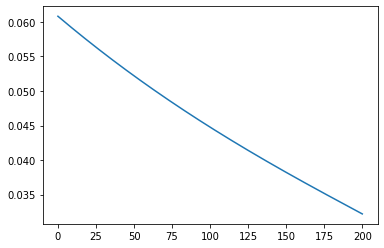

In [8]:
ϕ_low = ϕ
plt.plot(ϕ_low)

# With reserve constraint
$$
\begin{aligned}
0 = \max_{\tilde e}\min_h & \quad b \delta\eta \log\tilde e \\
&  + b \frac{\xi_m}{2} h'h + \frac{dV}{dy} \tilde e (\theta + \sigma_y h) - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2\\
& + b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot (\theta + \sigma_y h) + b\frac{1}{2}(\eta -1)(\gamma_2)(\tilde e)^2|\sigma_y|^2 - \ell \tilde e
\end{aligned}
$$

$$
h^* = - \frac{\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)}{b \xi_m} \cdot \tilde e \sigma_y
$$
Plug back into the HJB:
$$
\begin{aligned}
0 = \max_{\tilde e } \quad & b \delta\eta \log \tilde e + \frac{dV}{dy} \tilde e \theta - \delta b \frac{dV}{db} + \frac{1}{2}\frac{d^2V}{dy^2}|\sigma_y|^2(\tilde e)^2 \\ 
& +  b(\eta -1 )\cdot(\gamma_1 + \gamma_2 y)\cdot\tilde e\cdot \theta  + b\frac{1}{2}(\eta -1)(\gamma_2)(\tilde e)^2|\sigma_y|^2 \color{red}{ - \ell \tilde e}\\
& -\frac{1}{2b\xi_m}\left(\frac{dV}{dy} + b(\eta-1)(\gamma_1 + \gamma_2 y)\right)^2 (\tilde e)^2 |\sigma_y|^2
\end{aligned}
$$

$$
b \in (0,1]
$$

$$
y: \text{celsius}\quad^oC
$$

$$
    \theta: \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
    \sigma_y = 1.2 \theta:  \quad \text{celsius per gigatonne of carbon}, \quad ^oC/GtC
$$

$$
\tilde e: \quad \text{gigatonne of carbon}, \quad GtC
$$

$$
\gamma_1 = 1.7675\times 10^{-4}
$$

$$
\gamma_2 = 0.0044
$$

First order condition for $\tilde e ^*$:
$$
  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2} + b(\eta -1) \gamma_2 \right] \cdot|\sigma_y|^2\cdot(\tilde e)^2 + \left[\frac{dV}{dy}\theta + b(\eta - 1)(\gamma_1 + \gamma_2 y)\theta - \ell \right]\tilde e + b \delta\eta = 0
$$

$$
A =  \left[- \frac{1}{b\xi_m}\left( \frac{dV}{dy}  + b(\eta -1)(\gamma_1 + \gamma_2 y) \right)^2 + \frac{d^2V}{dy^2}+ b(\eta -1) \gamma_2 \right] \cdot|\sigma_y|^2
$$

$$
B = \left[\frac{dV}{dy} + b(\eta - 1)(\gamma_1 + \gamma_2 y)\right]\theta - \ell
$$ 

$$
C = b \delta\eta
$$
And
$$
\tilde e^* = \frac{-B -  \sqrt{B^2 - 4AC}}{2A}
$$

In [9]:
b_grid = np.linspace(1e-10, 1, 100)
y_grid = np.linspace(1e-10, 4, 100)
# mesh grid and construct state space
(y_mat, b_mat) = np.meshgrid(y_grid, b_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), b_mat.reshape(-1,1,order='F')])
hb = b_grid[1] - b_grid[0]
hy = y_grid[1] - y_grid[0]

In [11]:
# 2 state HJB with constraints
θ = 1.86/1000
δ = 0.01
η = 0.032

ϵ = 1
# ℓ = 1e-12
ξₘ = 1000
σy = 1.2*θ

γ3_list = np.array([0, 2*0.0197, 2*0.3853])
π_p = np.array([1/3, 1/3, 1/3])
tol = 1e-8
dΛ = γ1 + γ2*y_mat + π_p@γ3_list*(y_mat - ȳ)*(y_mat >ȳ)
ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)

v_dict = dict()
ems_dict = dict()
ℓ_step = 1e-16

for ℓ in [1e-12, 1e-5]:
    episode = 0
    lhs_error = 1
    ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
    ems_old = ems
    while lhs_error > tol:
        if episode ==0:
            v0 =  - δ*η*y_mat**2
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,hy)
        v0_dyy = derivatives_2d(v0,0,2,hy)
        v0_db = derivatives_2d(v0,1,1,hb)
        # updating controls

        print(np.min(ems))
        temp = v0_dy + b_mat*(η-1)*dΛ
        a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2 + b_mat*(η - 1)*ddΛ*σy**2
        b = temp*θ  - ℓ
        c = δ*η*b_mat
        Δ = b**2 - 4*c*a
        Δ[Δ<0] = 0
        ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
        ems_new[ems_new <= 0] = 1e-15
        ems = ems_new
        # HJB coefficient
        A =  np.zeros(y_mat.shape)
        B_y =  ems*θ
        B_b = - δ*b_mat
        C_yy = ems**2*σy**2/2
        C_bb = np.zeros(y_mat.shape)
        D = b_mat*δ*η*np.log(ems) + b_mat*(η-1)*(dΛ*ems*θ + 1/2*ddΛ*ems**2*σy**2)\
        - ℓ*ems - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode,
              rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
#         print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    
    v_dict[ℓ] = v0
    ems_dict[ℓ] = ems

0.3186407160373311
Episode 0: PDE Error: 0.001318976187; False Transient Error: 0.001194224996; Iterations: 1196; CG Error: 0.000000000089
6.754539284663241e-09
Episode 1: PDE Error: 0.001201093337; False Transient Error: 0.001109829247; Iterations: 734; CG Error: 0.000000000092
6.754539284663241e-09
Episode 2: PDE Error: 0.001114939659; False Transient Error: 0.001045846839; Iterations: 486; CG Error: 0.000000000094
6.754539282061156e-09
Episode 3: PDE Error: 0.001049135982; False Transient Error: 0.000994285175; Iterations: 346; CG Error: 0.000000000095
6.7545392803264326e-09
Episode 4: PDE Error: 0.000996431947; False Transient Error: 0.000951101708; Iterations: 267; CG Error: 0.000000000097
6.754539279459071e-09
Episode 5: PDE Error: 0.000952566383; False Transient Error: 0.000913927436; Iterations: 220; CG Error: 0.000000000091
6.754539279459071e-09
Episode 6: PDE Error: 0.000914970648; False Transient Error: 0.000881247254; Iterations: 190; CG Error: 0.000000000099
6.754539279459

Episode 72: PDE Error: 0.000339798474; False Transient Error: 0.000336491298; Iterations: 50; CG Error: 0.000000000077
6.754539279459071e-09
Episode 73: PDE Error: 0.000336491295; False Transient Error: 0.000333216409; Iterations: 50; CG Error: 0.000000000068
6.754539278591709e-09
Episode 74: PDE Error: 0.000333216406; False Transient Error: 0.000329973496; Iterations: 49; CG Error: 0.000000000089
6.7545392803264326e-09
Episode 75: PDE Error: 0.000329973494; False Transient Error: 0.000326762247; Iterations: 49; CG Error: 0.000000000079
6.754539279459071e-09
Episode 76: PDE Error: 0.000326762245; False Transient Error: 0.000323582352; Iterations: 49; CG Error: 0.000000000070
6.754539279459071e-09
Episode 77: PDE Error: 0.000323582350; False Transient Error: 0.000320433507; Iterations: 48; CG Error: 0.000000000094
6.754539279459071e-09
Episode 78: PDE Error: 0.000320433504; False Transient Error: 0.000317315407; Iterations: 48; CG Error: 0.000000000084
6.7545392803264326e-09
Episode 79:

Episode 152: PDE Error: 0.000155594759; False Transient Error: 0.000154086476; Iterations: 36; CG Error: 0.000000000088
6.7545392742549004e-09
Episode 153: PDE Error: 0.000154086474; False Transient Error: 0.000152592923; Iterations: 36; CG Error: 0.000000000085
6.754539275122262e-09
Episode 154: PDE Error: 0.000152592921; False Transient Error: 0.000151113958; Iterations: 36; CG Error: 0.000000000082
6.754539275989624e-09
Episode 155: PDE Error: 0.000151113957; False Transient Error: 0.000149649439; Iterations: 36; CG Error: 0.000000000079
6.754539275989624e-09
Episode 156: PDE Error: 0.000149649438; False Transient Error: 0.000148199225; Iterations: 36; CG Error: 0.000000000076
6.754539275989624e-09
Episode 157: PDE Error: 0.000148199223; False Transient Error: 0.000146763175; Iterations: 36; CG Error: 0.000000000073
6.754539275122262e-09
Episode 158: PDE Error: 0.000146763174; False Transient Error: 0.000145341152; Iterations: 36; CG Error: 0.000000000070
6.754539276856986e-09
Episo

6.754539278591709e-09
Episode 240: PDE Error: 0.000066271231; False Transient Error: 0.000065635223; Iterations: 33; CG Error: 0.000000000079
6.754539277724347e-09
Episode 241: PDE Error: 0.000065635224; False Transient Error: 0.000065005422; Iterations: 33; CG Error: 0.000000000078
6.754539277724347e-09
Episode 242: PDE Error: 0.000065005423; False Transient Error: 0.000064381764; Iterations: 33; CG Error: 0.000000000078
6.754539276856986e-09
Episode 243: PDE Error: 0.000064381765; False Transient Error: 0.000063764191; Iterations: 33; CG Error: 0.000000000077
6.754539277724347e-09
Episode 244: PDE Error: 0.000063764191; False Transient Error: 0.000063152641; Iterations: 33; CG Error: 0.000000000077
6.754539276856986e-09
Episode 245: PDE Error: 0.000063152642; False Transient Error: 0.000062547057; Iterations: 33; CG Error: 0.000000000076
6.754539275989624e-09
Episode 246: PDE Error: 0.000062547058; False Transient Error: 0.000061947379; Iterations: 33; CG Error: 0.000000000076
6.7545

Episode 301: PDE Error: 0.000036916102; False Transient Error: 0.000036565744; Iterations: 32; CG Error: 0.000000000080
6.754539257775027e-09
Episode 302: PDE Error: 0.000036565743; False Transient Error: 0.000036218774; Iterations: 32; CG Error: 0.000000000079
6.754539256907666e-09
Episode 303: PDE Error: 0.000036218773; False Transient Error: 0.000035875161; Iterations: 32; CG Error: 0.000000000078
6.754539256040304e-09
Episode 304: PDE Error: 0.000035875160; False Transient Error: 0.000035534871; Iterations: 32; CG Error: 0.000000000078
6.754539255172942e-09
Episode 305: PDE Error: 0.000035534870; False Transient Error: 0.000035197870; Iterations: 32; CG Error: 0.000000000077
6.754539256040304e-09
Episode 306: PDE Error: 0.000035197869; False Transient Error: 0.000034864127; Iterations: 32; CG Error: 0.000000000076
6.754539256040304e-09
Episode 307: PDE Error: 0.000034864126; False Transient Error: 0.000034533608; Iterations: 32; CG Error: 0.000000000076
6.754539255172942e-09
Episod

Episode 362: PDE Error: 0.000023232935; False Transient Error: 0.000020496163; Iterations: 31; CG Error: 0.000000000081
6.7545392543055804e-09
Episode 363: PDE Error: 0.000023132643; False Transient Error: 0.000020303238; Iterations: 31; CG Error: 0.000000000080
6.754539253438219e-09
Episode 364: PDE Error: 0.000023033078; False Transient Error: 0.000020112137; Iterations: 31; CG Error: 0.000000000079
6.754539253438219e-09
Episode 365: PDE Error: 0.000022934234; False Transient Error: 0.000019922845; Iterations: 31; CG Error: 0.000000000079
6.7545392543055804e-09
Episode 366: PDE Error: 0.000022836106; False Transient Error: 0.000019735342; Iterations: 31; CG Error: 0.000000000078
6.7545392543055804e-09
Episode 367: PDE Error: 0.000022738689; False Transient Error: 0.000019549611; Iterations: 31; CG Error: 0.000000000077
6.754539253438219e-09
Episode 368: PDE Error: 0.000022641978; False Transient Error: 0.000019365635; Iterations: 31; CG Error: 0.000000000077
6.7545392543055804e-09
Ep

Episode 425: PDE Error: 0.000018154041; False Transient Error: 0.000011292584; Iterations: 30; CG Error: 0.000000000082
6.754539272520177e-09
Episode 426: PDE Error: 0.000018091052; False Transient Error: 0.000011185976; Iterations: 30; CG Error: 0.000000000081
6.754539271652815e-09
Episode 427: PDE Error: 0.000018028538; False Transient Error: 0.000011080359; Iterations: 30; CG Error: 0.000000000080
6.754539272520177e-09
Episode 428: PDE Error: 0.000017966496; False Transient Error: 0.000010975726; Iterations: 30; CG Error: 0.000000000080
6.754539272520177e-09
Episode 429: PDE Error: 0.000017904923; False Transient Error: 0.000010872066; Iterations: 30; CG Error: 0.000000000079
6.754539272520177e-09
Episode 430: PDE Error: 0.000017843815; False Transient Error: 0.000010769371; Iterations: 30; CG Error: 0.000000000078
6.754539273387539e-09
Episode 431: PDE Error: 0.000017783169; False Transient Error: 0.000010667632; Iterations: 30; CG Error: 0.000000000077
6.7545392742549004e-09
Episo

Episode 489: PDE Error: 0.000020069062; False Transient Error: 0.000006134303; Iterations: 29; CG Error: 0.000000000079
6.7545392837958795e-09
Episode 490: PDE Error: 0.000020106268; False Transient Error: 0.000006075738; Iterations: 29; CG Error: 0.000000000079
6.7545392837958795e-09
Episode 491: PDE Error: 0.000020143176; False Transient Error: 0.000006017721; Iterations: 29; CG Error: 0.000000000078
6.7545392837958795e-09
Episode 492: PDE Error: 0.000020179787; False Transient Error: 0.000005960247; Iterations: 29; CG Error: 0.000000000077
6.7545392837958795e-09
Episode 493: PDE Error: 0.000020216104; False Transient Error: 0.000005903311; Iterations: 29; CG Error: 0.000000000077
6.754539282928518e-09
Episode 494: PDE Error: 0.000020252128; False Transient Error: 0.000005846908; Iterations: 29; CG Error: 0.000000000076
6.754539282928518e-09
Episode 495: PDE Error: 0.000020287861; False Transient Error: 0.000005791032; Iterations: 29; CG Error: 0.000000000075
6.7545392837958795e-09
E

Episode 554: PDE Error: 0.000021947683; False Transient Error: 0.000003275867; Iterations: 28; CG Error: 0.000000000070
6.754539273387539e-09
Episode 555: PDE Error: 0.000021969253; False Transient Error: 0.000003244222; Iterations: 28; CG Error: 0.000000000069
6.754539272520177e-09
Episode 556: PDE Error: 0.000021990636; False Transient Error: 0.000003212877; Iterations: 28; CG Error: 0.000000000069
6.754539272520177e-09
Episode 557: PDE Error: 0.000022011835; False Transient Error: 0.000003181830; Iterations: 28; CG Error: 0.000000000068
6.754539272520177e-09
Episode 558: PDE Error: 0.000022032849; False Transient Error: 0.000003151079; Iterations: 28; CG Error: 0.000000000067
6.754539271652815e-09
Episode 559: PDE Error: 0.000022053680; False Transient Error: 0.000003120620; Iterations: 28; CG Error: 0.000000000067
6.754539271652815e-09
Episode 560: PDE Error: 0.000022074331; False Transient Error: 0.000003090450; Iterations: 28; CG Error: 0.000000000066
6.754539272520177e-09
Episod

Episode 622: PDE Error: 0.000023054462; False Transient Error: 0.000001687732; Iterations: 26; CG Error: 0.000000000097
6.754539269918092e-09
Episode 623: PDE Error: 0.000023066205; False Transient Error: 0.000001671284; Iterations: 26; CG Error: 0.000000000096
6.754539269918092e-09
Episode 624: PDE Error: 0.000023077841; False Transient Error: 0.000001654994; Iterations: 26; CG Error: 0.000000000095
6.7545392707854535e-09
Episode 625: PDE Error: 0.000023089371; False Transient Error: 0.000001638862; Iterations: 26; CG Error: 0.000000000094
6.7545392707854535e-09
Episode 626: PDE Error: 0.000023100796; False Transient Error: 0.000001622885; Iterations: 26; CG Error: 0.000000000093
6.7545392707854535e-09
Episode 627: PDE Error: 0.000023112116; False Transient Error: 0.000001607063; Iterations: 26; CG Error: 0.000000000092
6.754539271652815e-09
Episode 628: PDE Error: 0.000023123334; False Transient Error: 0.000001591393; Iterations: 26; CG Error: 0.000000000091
6.754539272520177e-09
Epi

Episode 692: PDE Error: 0.000023662333; False Transient Error: 0.000000848586; Iterations: 25; CG Error: 0.000000000083
6.754539285530603e-09
Episode 693: PDE Error: 0.000023668456; False Transient Error: 0.000000840271; Iterations: 25; CG Error: 0.000000000082
6.754539286397965e-09
Episode 694: PDE Error: 0.000023674521; False Transient Error: 0.000000832037; Iterations: 25; CG Error: 0.000000000082
6.754539284663241e-09
Episode 695: PDE Error: 0.000023680529; False Transient Error: 0.000000823883; Iterations: 25; CG Error: 0.000000000081
6.754539285530603e-09
Episode 696: PDE Error: 0.000023686480; False Transient Error: 0.000000815809; Iterations: 25; CG Error: 0.000000000080
6.754539286397965e-09
Episode 697: PDE Error: 0.000023692376; False Transient Error: 0.000000807814; Iterations: 25; CG Error: 0.000000000079
6.754539286397965e-09
Episode 698: PDE Error: 0.000023698216; False Transient Error: 0.000000799896; Iterations: 25; CG Error: 0.000000000079
6.7545392872653265e-09
Episo

Episode 763: PDE Error: 0.000023980152; False Transient Error: 0.000000421281; Iterations: 24; CG Error: 0.000000000068
6.754539284663241e-09
Episode 764: PDE Error: 0.000023983267; False Transient Error: 0.000000417141; Iterations: 24; CG Error: 0.000000000067
6.754539285530603e-09
Episode 765: PDE Error: 0.000023986353; False Transient Error: 0.000000413041; Iterations: 24; CG Error: 0.000000000066
6.754539284663241e-09
Episode 766: PDE Error: 0.000023989410; False Transient Error: 0.000000408982; Iterations: 24; CG Error: 0.000000000066
6.7545392837958795e-09
Episode 767: PDE Error: 0.000023992437; False Transient Error: 0.000000404962; Iterations: 24; CG Error: 0.000000000065
6.754539285530603e-09
Episode 768: PDE Error: 0.000023995436; False Transient Error: 0.000000400982; Iterations: 24; CG Error: 0.000000000064
6.754539285530603e-09
Episode 769: PDE Error: 0.000023998406; False Transient Error: 0.000000397040; Iterations: 24; CG Error: 0.000000000064
6.7545392837958795e-09
Epis

6.754539276856986e-09
Episode 833: PDE Error: 0.000024139669; False Transient Error: 0.000000210898; Iterations: 23; CG Error: 0.000000000058
6.754539275989624e-09
Episode 834: PDE Error: 0.000024141257; False Transient Error: 0.000000208822; Iterations: 23; CG Error: 0.000000000058
6.754539275989624e-09
Episode 835: PDE Error: 0.000024142830; False Transient Error: 0.000000206766; Iterations: 23; CG Error: 0.000000000057
6.754539275989624e-09
Episode 836: PDE Error: 0.000024144387; False Transient Error: 0.000000204732; Iterations: 22; CG Error: 0.000000000100
6.754539275122262e-09
Episode 837: PDE Error: 0.000024145930; False Transient Error: 0.000000202716; Iterations: 22; CG Error: 0.000000000099
6.754539275122262e-09
Episode 838: PDE Error: 0.000024147458; False Transient Error: 0.000000200721; Iterations: 22; CG Error: 0.000000000098
6.754539277724347e-09
Episode 839: PDE Error: 0.000024148971; False Transient Error: 0.000000198745; Iterations: 22; CG Error: 0.000000000097
6.7545

Episode 907: PDE Error: 0.000024223979; False Transient Error: 0.000000101398; Iterations: 21; CG Error: 0.000000000079
6.754539284663241e-09
Episode 908: PDE Error: 0.000024224754; False Transient Error: 0.000000100399; Iterations: 21; CG Error: 0.000000000079
6.754539284663241e-09
Episode 909: PDE Error: 0.000024225522; False Transient Error: 0.000000099410; Iterations: 21; CG Error: 0.000000000078
6.754539285530603e-09
Episode 910: PDE Error: 0.000024226283; False Transient Error: 0.000000098431; Iterations: 21; CG Error: 0.000000000077
6.754539285530603e-09
Episode 911: PDE Error: 0.000024227036; False Transient Error: 0.000000097461; Iterations: 21; CG Error: 0.000000000076
6.754539285530603e-09
Episode 912: PDE Error: 0.000024227781; False Transient Error: 0.000000096501; Iterations: 21; CG Error: 0.000000000076
6.754539286397965e-09
Episode 913: PDE Error: 0.000024228520; False Transient Error: 0.000000095550; Iterations: 21; CG Error: 0.000000000075
6.754539285530603e-09
Episod

6.7545392907347734e-09
Episode 979: PDE Error: 0.000024264313; False Transient Error: 0.000000049705; Iterations: 20; CG Error: 0.000000000061
6.7545392907347734e-09
Episode 980: PDE Error: 0.000024264698; False Transient Error: 0.000000049215; Iterations: 20; CG Error: 0.000000000060
6.7545392907347734e-09
Episode 981: PDE Error: 0.000024265079; False Transient Error: 0.000000048730; Iterations: 20; CG Error: 0.000000000060
6.7545392907347734e-09
Episode 982: PDE Error: 0.000024265456; False Transient Error: 0.000000048250; Iterations: 19; CG Error: 0.000000000099
6.7545392907347734e-09
Episode 983: PDE Error: 0.000024265830; False Transient Error: 0.000000047774; Iterations: 19; CG Error: 0.000000000098
6.754539289867412e-09
Episode 984: PDE Error: 0.000024266201; False Transient Error: 0.000000047304; Iterations: 19; CG Error: 0.000000000097
6.7545392907347734e-09
Episode 985: PDE Error: 0.000024266567; False Transient Error: 0.000000046838; Iterations: 19; CG Error: 0.000000000096


Episode 1057: PDE Error: 0.000024285430; False Transient Error: 0.000000022956; Iterations: 18; CG Error: 0.000000000078
6.754539284663241e-09
Episode 1058: PDE Error: 0.000024285610; False Transient Error: 0.000000022729; Iterations: 18; CG Error: 0.000000000077
6.754539284663241e-09
Episode 1059: PDE Error: 0.000024285788; False Transient Error: 0.000000022505; Iterations: 18; CG Error: 0.000000000077
6.754539284663241e-09
Episode 1060: PDE Error: 0.000024285964; False Transient Error: 0.000000022283; Iterations: 18; CG Error: 0.000000000076
6.7545392837958795e-09
Episode 1061: PDE Error: 0.000024286138; False Transient Error: 0.000000022064; Iterations: 18; CG Error: 0.000000000075
6.754539285530603e-09
Episode 1062: PDE Error: 0.000024286311; False Transient Error: 0.000000021846; Iterations: 18; CG Error: 0.000000000074
6.754539284663241e-09
Episode 1063: PDE Error: 0.000024286482; False Transient Error: 0.000000021631; Iterations: 18; CG Error: 0.000000000074
6.754539284663241e-0

Episode 1139: PDE Error: 0.000024295624; False Transient Error: 0.000000010186; Iterations: 16; CG Error: 0.000000000092
6.754539292469497e-09
Episode 1140: PDE Error: 0.000024295705; False Transient Error: 0.000000010086; Iterations: 16; CG Error: 0.000000000090
6.754539291602135e-09
Episode 1141: PDE Error: 0.000024295785; False Transient Error: 0.000000009986; Iterations: 16; CG Error: 0.000000000090
0.3186407160373311
Episode 0: PDE Error: 0.000767345626; False Transient Error: 0.000744651373; Iterations: 78; CG Error: 0.000000000083
2.1713239296838882e-09
Episode 1: PDE Error: 0.000744865579; False Transient Error: 0.000723815705; Iterations: 76; CG Error: 0.000000000077
2.1713239296838882e-09
Episode 2: PDE Error: 0.000723991816; False Transient Error: 0.000704335494; Iterations: 74; CG Error: 0.000000000079
2.1713239296838882e-09
Episode 3: PDE Error: 0.000704481929; False Transient Error: 0.000686021395; Iterations: 72; CG Error: 0.000000000089
2.1713239296838882e-09
Episode 4:

Episode 66: PDE Error: 0.000363364403; False Transient Error: 0.000359854861; Iterations: 44; CG Error: 0.000000000081
2.1713239296838882e-09
Episode 67: PDE Error: 0.000359854858; False Transient Error: 0.000356379563; Iterations: 44; CG Error: 0.000000000075
2.1713239296838882e-09
Episode 68: PDE Error: 0.000356379560; False Transient Error: 0.000352938179; Iterations: 44; CG Error: 0.000000000070
2.1713239296838882e-09
Episode 69: PDE Error: 0.000352938176; False Transient Error: 0.000349530377; Iterations: 44; CG Error: 0.000000000066
2.1713239296838882e-09
Episode 70: PDE Error: 0.000349530374; False Transient Error: 0.000346155830; Iterations: 43; CG Error: 0.000000000094
2.171323933153335e-09
Episode 71: PDE Error: 0.000346155826; False Transient Error: 0.000342814213; Iterations: 43; CG Error: 0.000000000089
2.1713239296838882e-09
Episode 72: PDE Error: 0.000342814209; False Transient Error: 0.000339505205; Iterations: 43; CG Error: 0.000000000083
2.1713239296838882e-09
Episode

Episode 149: PDE Error: 0.000163077088; False Transient Error: 0.000161521603; Iterations: 35; CG Error: 0.000000000075
2.1713239296838882e-09
Episode 150: PDE Error: 0.000161521601; False Transient Error: 0.000159981280; Iterations: 35; CG Error: 0.000000000073
2.1713239296838882e-09
Episode 151: PDE Error: 0.000159981278; False Transient Error: 0.000158455973; Iterations: 35; CG Error: 0.000000000070
2.1713239262144413e-09
Episode 152: PDE Error: 0.000158455971; False Transient Error: 0.000156945534; Iterations: 35; CG Error: 0.000000000068
2.171323933153335e-09
Episode 153: PDE Error: 0.000156945533; False Transient Error: 0.000155449819; Iterations: 35; CG Error: 0.000000000066
2.171323933153335e-09
Episode 154: PDE Error: 0.000155449818; False Transient Error: 0.000153968683; Iterations: 35; CG Error: 0.000000000065
2.171323933153335e-09
Episode 155: PDE Error: 0.000153968682; False Transient Error: 0.000152501984; Iterations: 35; CG Error: 0.000000000063
2.1713239296838882e-09
Ep

Episode 209: PDE Error: 0.000092146629; False Transient Error: 0.000091281704; Iterations: 33; CG Error: 0.000000000097
2.1713239296838882e-09
Episode 210: PDE Error: 0.000091281706; False Transient Error: 0.000090425180; Iterations: 33; CG Error: 0.000000000097
2.171323933153335e-09
Episode 211: PDE Error: 0.000090425182; False Transient Error: 0.000089576973; Iterations: 33; CG Error: 0.000000000096
2.1713239296838882e-09
Episode 212: PDE Error: 0.000089576975; False Transient Error: 0.000088737001; Iterations: 33; CG Error: 0.000000000095
2.1713239296838882e-09
Episode 213: PDE Error: 0.000088737003; False Transient Error: 0.000087905182; Iterations: 33; CG Error: 0.000000000094
2.171323933153335e-09
Episode 214: PDE Error: 0.000087905184; False Transient Error: 0.000087081438; Iterations: 33; CG Error: 0.000000000094
2.1713239296838882e-09
Episode 215: PDE Error: 0.000087081440; False Transient Error: 0.000086265688; Iterations: 33; CG Error: 0.000000000093
2.1713239296838882e-09
E

2.1713239296838882e-09
Episode 271: PDE Error: 0.000051681796; False Transient Error: 0.000051207822; Iterations: 32; CG Error: 0.000000000097
2.1713239296838882e-09
Episode 272: PDE Error: 0.000051207821; False Transient Error: 0.000050738380; Iterations: 32; CG Error: 0.000000000096
2.1713239296838882e-09
Episode 273: PDE Error: 0.000050738378; False Transient Error: 0.000050273425; Iterations: 32; CG Error: 0.000000000095
2.1713239296838882e-09
Episode 274: PDE Error: 0.000050273424; False Transient Error: 0.000049812914; Iterations: 32; CG Error: 0.000000000095
2.1713239296838882e-09
Episode 275: PDE Error: 0.000049812912; False Transient Error: 0.000049356801; Iterations: 32; CG Error: 0.000000000094
2.171323933153335e-09
Episode 276: PDE Error: 0.000049356799; False Transient Error: 0.000048905043; Iterations: 32; CG Error: 0.000000000093
2.1713239296838882e-09
Episode 277: PDE Error: 0.000048905041; False Transient Error: 0.000048457596; Iterations: 32; CG Error: 0.000000000092


Episode 332: PDE Error: 0.000030376827; False Transient Error: 0.000029373882; Iterations: 32; CG Error: 0.000000000059
2.1713239262144413e-09
Episode 333: PDE Error: 0.000030229940; False Transient Error: 0.000029109830; Iterations: 32; CG Error: 0.000000000058
2.1713239262144413e-09
Episode 334: PDE Error: 0.000030083950; False Transient Error: 0.000028848198; Iterations: 31; CG Error: 0.000000000099
2.1713239296838882e-09
Episode 335: PDE Error: 0.000029938853; False Transient Error: 0.000028588966; Iterations: 31; CG Error: 0.000000000099
2.1713239296838882e-09
Episode 336: PDE Error: 0.000029794643; False Transient Error: 0.000028332108; Iterations: 31; CG Error: 0.000000000098
2.1713239262144413e-09
Episode 337: PDE Error: 0.000029651316; False Transient Error: 0.000028077600; Iterations: 31; CG Error: 0.000000000097
2.1713239262144413e-09
Episode 338: PDE Error: 0.000029508865; False Transient Error: 0.000027825418; Iterations: 31; CG Error: 0.000000000096
2.1713239262144413e-09

Episode 395: PDE Error: 0.000022689851; False Transient Error: 0.000016645351; Iterations: 31; CG Error: 0.000000000060
2.1713239262144413e-09
Episode 396: PDE Error: 0.000022590746; False Transient Error: 0.000016495547; Iterations: 31; CG Error: 0.000000000059
2.1713239262144413e-09
Episode 397: PDE Error: 0.000022492279; False Transient Error: 0.000016347057; Iterations: 31; CG Error: 0.000000000059
2.1713239296838882e-09
Episode 398: PDE Error: 0.000022394448; False Transient Error: 0.000016199872; Iterations: 31; CG Error: 0.000000000058
2.1713239296838882e-09
Episode 399: PDE Error: 0.000022297249; False Transient Error: 0.000016053977; Iterations: 31; CG Error: 0.000000000058
2.1713239296838882e-09
Episode 400: PDE Error: 0.000022200679; False Transient Error: 0.000015909363; Iterations: 31; CG Error: 0.000000000057
2.1713239296838882e-09
Episode 401: PDE Error: 0.000022104735; False Transient Error: 0.000015766017; Iterations: 30; CG Error: 0.000000000100
2.1713239296838882e-09

Episode 459: PDE Error: 0.000017515400; False Transient Error: 0.000009280283; Iterations: 30; CG Error: 0.000000000060
2.1713239296838882e-09
Episode 460: PDE Error: 0.000017451533; False Transient Error: 0.000009194935; Iterations: 30; CG Error: 0.000000000059
2.1713239296838882e-09
Episode 461: PDE Error: 0.000017388133; False Transient Error: 0.000009110338; Iterations: 30; CG Error: 0.000000000059
2.1713239296838882e-09
Episode 462: PDE Error: 0.000017325198; False Transient Error: 0.000009026484; Iterations: 29; CG Error: 0.000000000099
2.1713239296838882e-09
Episode 463: PDE Error: 0.000017262725; False Transient Error: 0.000008943369; Iterations: 29; CG Error: 0.000000000098
2.1713239296838882e-09
Episode 464: PDE Error: 0.000017200711; False Transient Error: 0.000008860985; Iterations: 29; CG Error: 0.000000000098
2.1713239296838882e-09
Episode 465: PDE Error: 0.000017139154; False Transient Error: 0.000008779327; Iterations: 29; CG Error: 0.000000000097
2.1713239296838882e-09

Episode 523: PDE Error: 0.000019933826; False Transient Error: 0.000005098608; Iterations: 28; CG Error: 0.000000000091
2.1713239296838882e-09
Episode 524: PDE Error: 0.000019972172; False Transient Error: 0.000005050519; Iterations: 28; CG Error: 0.000000000090
2.1713239296838882e-09
Episode 525: PDE Error: 0.000020010204; False Transient Error: 0.000005002866; Iterations: 28; CG Error: 0.000000000090
2.1713239296838882e-09
Episode 526: PDE Error: 0.000020047925; False Transient Error: 0.000004955646; Iterations: 28; CG Error: 0.000000000089
2.1713239296838882e-09
Episode 527: PDE Error: 0.000020085336; False Transient Error: 0.000004908855; Iterations: 28; CG Error: 0.000000000088
2.1713239296838882e-09
Episode 528: PDE Error: 0.000020122439; False Transient Error: 0.000004862490; Iterations: 28; CG Error: 0.000000000087
2.1713239296838882e-09
Episode 529: PDE Error: 0.000020159237; False Transient Error: 0.000004816546; Iterations: 28; CG Error: 0.000000000086
2.1713239262144413e-09

Episode 589: PDE Error: 0.000021880942; False Transient Error: 0.000002709999; Iterations: 27; CG Error: 0.000000000079
2.1713239262144413e-09
Episode 590: PDE Error: 0.000021902677; False Transient Error: 0.000002683930; Iterations: 27; CG Error: 0.000000000078
2.1713239296838882e-09
Episode 591: PDE Error: 0.000021924218; False Transient Error: 0.000002658106; Iterations: 27; CG Error: 0.000000000078
2.1713239262144413e-09
Episode 592: PDE Error: 0.000021945567; False Transient Error: 0.000002632524; Iterations: 27; CG Error: 0.000000000077
2.171323933153335e-09
Episode 593: PDE Error: 0.000021966725; False Transient Error: 0.000002607182; Iterations: 27; CG Error: 0.000000000076
2.1713239296838882e-09
Episode 594: PDE Error: 0.000021987695; False Transient Error: 0.000002582078; Iterations: 27; CG Error: 0.000000000075
2.1713239262144413e-09
Episode 595: PDE Error: 0.000022008477; False Transient Error: 0.000002557211; Iterations: 27; CG Error: 0.000000000075
2.1713239296838882e-09


Episode 657: PDE Error: 0.000022987939; False Transient Error: 0.000001398164; Iterations: 26; CG Error: 0.000000000070
2.1713239262144413e-09
Episode 658: PDE Error: 0.000022999577; False Transient Error: 0.000001384544; Iterations: 26; CG Error: 0.000000000070
2.1713239296838882e-09
Episode 659: PDE Error: 0.000023011106; False Transient Error: 0.000001371055; Iterations: 26; CG Error: 0.000000000069
2.171323933153335e-09
Episode 660: PDE Error: 0.000023022526; False Transient Error: 0.000001357695; Iterations: 26; CG Error: 0.000000000068
2.1713239296838882e-09
Episode 661: PDE Error: 0.000023033840; False Transient Error: 0.000001344464; Iterations: 26; CG Error: 0.000000000068
2.1713239296838882e-09
Episode 662: PDE Error: 0.000023045048; False Transient Error: 0.000001331360; Iterations: 26; CG Error: 0.000000000067
2.1713239262144413e-09
Episode 663: PDE Error: 0.000023056152; False Transient Error: 0.000001318382; Iterations: 26; CG Error: 0.000000000066
2.1713239296838882e-09


Episode 727: PDE Error: 0.000023586097; False Transient Error: 0.000000702733; Iterations: 24; CG Error: 0.000000000098
2.1713239296838882e-09
Episode 728: PDE Error: 0.000023592069; False Transient Error: 0.000000695838; Iterations: 24; CG Error: 0.000000000097
2.1713239296838882e-09
Episode 729: PDE Error: 0.000023597983; False Transient Error: 0.000000689010; Iterations: 24; CG Error: 0.000000000096
2.1713239296838882e-09
Episode 730: PDE Error: 0.000023603841; False Transient Error: 0.000000682249; Iterations: 24; CG Error: 0.000000000095
2.1713239296838882e-09
Episode 731: PDE Error: 0.000023609643; False Transient Error: 0.000000675553; Iterations: 24; CG Error: 0.000000000094
2.1713239296838882e-09
Episode 732: PDE Error: 0.000023615389; False Transient Error: 0.000000668923; Iterations: 24; CG Error: 0.000000000093
2.1713239296838882e-09
Episode 733: PDE Error: 0.000023621079; False Transient Error: 0.000000662357; Iterations: 24; CG Error: 0.000000000092
2.1713239296838882e-09

Episode 799: PDE Error: 0.000023897115; False Transient Error: 0.000000345002; Iterations: 23; CG Error: 0.000000000085
2.1713239296838882e-09
Episode 800: PDE Error: 0.000023900082; False Transient Error: 0.000000341603; Iterations: 23; CG Error: 0.000000000084
2.1713239296838882e-09
Episode 801: PDE Error: 0.000023903020; False Transient Error: 0.000000338239; Iterations: 23; CG Error: 0.000000000083
2.1713239296838882e-09
Episode 802: PDE Error: 0.000023905929; False Transient Error: 0.000000334907; Iterations: 23; CG Error: 0.000000000082
2.1713239296838882e-09
Episode 803: PDE Error: 0.000023908809; False Transient Error: 0.000000331608; Iterations: 23; CG Error: 0.000000000081
2.1713239296838882e-09
Episode 804: PDE Error: 0.000023911662; False Transient Error: 0.000000328341; Iterations: 23; CG Error: 0.000000000080
2.1713239262144413e-09
Episode 805: PDE Error: 0.000023914487; False Transient Error: 0.000000325107; Iterations: 23; CG Error: 0.000000000080
2.1713239296838882e-09

Episode 872: PDE Error: 0.000024052541; False Transient Error: 0.000000167370; Iterations: 22; CG Error: 0.000000000071
2.1713239296838882e-09
Episode 873: PDE Error: 0.000024053990; False Transient Error: 0.000000165719; Iterations: 22; CG Error: 0.000000000071
2.1713239262144413e-09
Episode 874: PDE Error: 0.000024055425; False Transient Error: 0.000000164083; Iterations: 22; CG Error: 0.000000000070
2.1713239296838882e-09
Episode 875: PDE Error: 0.000024056846; False Transient Error: 0.000000162464; Iterations: 22; CG Error: 0.000000000069
2.171323933153335e-09
Episode 876: PDE Error: 0.000024058252; False Transient Error: 0.000000160861; Iterations: 22; CG Error: 0.000000000069
2.1713239296838882e-09
Episode 877: PDE Error: 0.000024059645; False Transient Error: 0.000000159274; Iterations: 22; CG Error: 0.000000000068
2.1713239296838882e-09
Episode 878: PDE Error: 0.000024061025; False Transient Error: 0.000000157702; Iterations: 22; CG Error: 0.000000000067
2.1713239296838882e-09


Episode 948: PDE Error: 0.000024130421; False Transient Error: 0.000000078735; Iterations: 20; CG Error: 0.000000000085
2.1713239296838882e-09
Episode 949: PDE Error: 0.000024131105; False Transient Error: 0.000000077958; Iterations: 20; CG Error: 0.000000000084
2.1713239296838882e-09
Episode 950: PDE Error: 0.000024131783; False Transient Error: 0.000000077188; Iterations: 20; CG Error: 0.000000000083
2.1713239296838882e-09
Episode 951: PDE Error: 0.000024132454; False Transient Error: 0.000000076425; Iterations: 20; CG Error: 0.000000000083
2.1713239296838882e-09
Episode 952: PDE Error: 0.000024133119; False Transient Error: 0.000000075670; Iterations: 20; CG Error: 0.000000000082
2.1713239296838882e-09
Episode 953: PDE Error: 0.000024133777; False Transient Error: 0.000000074922; Iterations: 20; CG Error: 0.000000000081
2.1713239296838882e-09
Episode 954: PDE Error: 0.000024134428; False Transient Error: 0.000000074182; Iterations: 20; CG Error: 0.000000000080
2.171323933153335e-09


Episode 1026: PDE Error: 0.000024167830; False Transient Error: 0.000000036290; Iterations: 19; CG Error: 0.000000000068
2.1713239296838882e-09
Episode 1027: PDE Error: 0.000024168147; False Transient Error: 0.000000035931; Iterations: 19; CG Error: 0.000000000067
2.1713239296838882e-09
Episode 1028: PDE Error: 0.000024168460; False Transient Error: 0.000000035576; Iterations: 19; CG Error: 0.000000000066
2.1713239296838882e-09
Episode 1029: PDE Error: 0.000024168771; False Transient Error: 0.000000035224; Iterations: 19; CG Error: 0.000000000066
2.1713239296838882e-09
Episode 1030: PDE Error: 0.000024169078; False Transient Error: 0.000000034876; Iterations: 19; CG Error: 0.000000000065
2.1713239296838882e-09
Episode 1031: PDE Error: 0.000024169383; False Transient Error: 0.000000034531; Iterations: 19; CG Error: 0.000000000064
2.1713239296838882e-09
Episode 1032: PDE Error: 0.000024169684; False Transient Error: 0.000000034190; Iterations: 19; CG Error: 0.000000000064
2.1713239296838

Episode 1107: PDE Error: 0.000024185556; False Transient Error: 0.000000016232; Iterations: 17; CG Error: 0.000000000078
2.171323933153335e-09
Episode 1108: PDE Error: 0.000024185698; False Transient Error: 0.000000016072; Iterations: 17; CG Error: 0.000000000075
2.1713239296838882e-09
Episode 1109: PDE Error: 0.000024185838; False Transient Error: 0.000000015913; Iterations: 17; CG Error: 0.000000000076
2.1713239296838882e-09
Episode 1110: PDE Error: 0.000024185977; False Transient Error: 0.000000015756; Iterations: 17; CG Error: 0.000000000073
2.1713239296838882e-09
Episode 1111: PDE Error: 0.000024186115; False Transient Error: 0.000000015600; Iterations: 17; CG Error: 0.000000000075
2.1713239296838882e-09
Episode 1112: PDE Error: 0.000024186251; False Transient Error: 0.000000015446; Iterations: 17; CG Error: 0.000000000072
2.1713239296838882e-09
Episode 1113: PDE Error: 0.000024186386; False Transient Error: 0.000000015293; Iterations: 17; CG Error: 0.000000000073
2.17132392968388

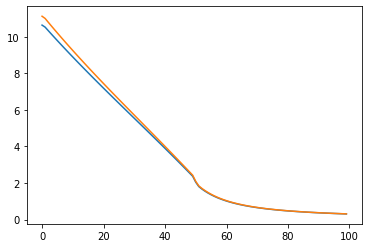

In [12]:
plt.plot(ems_dict[1e-5][:,-1])
plt.plot(ems_dict[1e-12][:,-1])

In [13]:
def compute_h_2d(ϕ, y_mat, b_mat, ems, args=(η, σy, γ1, γ2, ξₘ)):
    η, σy, γ1, γ2, ξₘ = args
    dΛ = γ1 + γ2*y_mat
    dy = y_mat[1,0] - y_mat[0,0]
    dϕdy = derivatives_2d(ϕ, 0, 1, dy)
    h_star = dϕdy + b_mat*(η-1)*dΛ
    h_star *= ems*σy
    h_star *= - 1/(b_mat*ξₘ)
    return h_star

In [14]:
args=(η, σy, γ1, γ2, ξₘ)
h_2d_dict = dict()
for ℓ in [1e-12, 1e-5]:
    h_2d_dict[ℓ] = compute_h_2d(v_dict[ℓ], y_mat, b_mat, ems_dict[ℓ], args)

(0.0, 0.3)

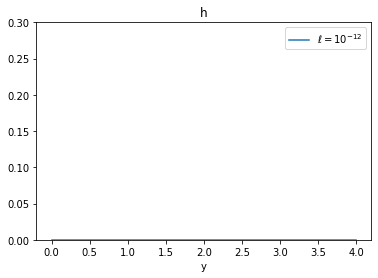

In [15]:
# plt.plot(y_grid[:], h_1d[:], label="no constraint")
plt.plot(y_mat[:,0], h_2d_dict[1e-12][:,-1], label="$ℓ = 10^{-12}$")
# plt.plot(y_mat[:,0], h_2d_dict[1e-5][:,-1], label="$ℓ = 10^{-5}$")
plt.legend()
plt.xlabel('y')
plt.title('h')
plt.ylim(0,0.3)
# plt.savefig("h_star.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

In [81]:
# 2 state HJB with constraints
θ = 1.86/1000
δ = 0.01
η = 0.032

ϵ = 1
# ℓ = 1e-12
ξₘ = 1000
σy = 1.2*θ

γ3_list = np.array([0, 2*0.0197, 2*0.3853])
π_p = np.array([1, 0, 0])
dΛ = γ1 + γ2*y_mat + π_p@γ3_list*(y_mat - ȳ)*(y_mat >ȳ)
ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
R_max = 9000

tol = 1e-7
ℓ = 1e-5
ℓ_step = 1e-12

# ℓ_list = [ℓ, ℓ+ℓ_step]
power_ℓ_list = np.linspace(-5, 3, 10)
ℓ_list = 10**power_ℓ_list

In [71]:
# numbe V_ℓ
V_dict = dict()
E_dict = dict()
for ℓ in ℓ_list:
    for ℓ_i in [ℓ, ℓ + ℓ_step]:
        episode = 0
        lhs_error = 1
        ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
        ems_old = ems
        while lhs_error > tol:
            if episode ==0:
                v0 =  - δ*η*y_mat**2
            else:
                vold = v0.copy()
            v0_dy = derivatives_2d(v0,0,1,hy)
            v0_dyy = derivatives_2d(v0,0,2,hy)
            v0_db = derivatives_2d(v0,1,1,hb)
            # updating controls

            print(np.min(ems))
            temp = v0_dy + b_mat*(η-1)*dΛ
            a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2+ b_mat*(η - 1)*ddΛ*σy**2
            b = temp*θ  - ℓ_i*θ 
            c = δ*η*b_mat
            Δ = b**2 - 4*c*a
            Δ[Δ<0] = 0
            ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
            ems_new[ems_new <= 0] = 1e-15
            ems = ems_new
            # HJB coefficient
            A =  np.zeros(y_mat.shape)
            B_y =  ems*θ
            B_b = - δ*b_mat
            C_yy = ems**2*σy**2/2
            C_bb = np.zeros(y_mat.shape)
            D = b_mat*δ*η*np.log(ems) +  b_mat*(η-1)*(dΛ*ems*θ + 1/2*ddΛ*ems**2*σy**2)\
            - ℓ_i*ems*θ - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
            # PDE solver
            solve_start = time.time()
            out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
            out_comp = out[2].reshape(v0.shape,order = "F")
            rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
            rhs_error = np.max(abs(rhs))
            lhs_error = np.max(abs((out_comp - v0)))
            #     if episode % 1 == 0:
            print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
            episode += 1
            v0 = out_comp
            ems_old = ems
            print("End of PDE solver, takes time: {}".format(time.time() - solve_start))

        V_dict[ℓ_i] = v0

9.997912048545173
Episode 0: PDE Error: 0.001316976289; False Transient Error: 0.001192800277; Iterations: 1188; CG Error: 0.000000000095
End of PDE solver, takes time: 0.13410663604736328
6.7281257223536506e-09
Episode 1: PDE Error: 0.001199630869; False Transient Error: 0.001108732649; Iterations: 731; CG Error: 0.000000000099
End of PDE solver, takes time: 0.08584046363830566
6.728125723221012e-09
Episode 2: PDE Error: 0.001113808949; False Transient Error: 0.001044945731; Iterations: 483; CG Error: 0.000000000098
End of PDE solver, takes time: 0.05586695671081543
6.728125723221012e-09
Episode 3: PDE Error: 0.001048214072; False Transient Error: 0.000993514470; Iterations: 346; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0399014949798584
6.728125723221012e-09
Episode 4: PDE Error: 0.000995648990; False Transient Error: 0.000950424085; Iterations: 267; CG Error: 0.000000000097
End of PDE solver, takes time: 0.04260563850402832
6.728125723221012e-09
Episode 5: PDE Error:

6.728125724088374e-09
Episode 52: PDE Error: 0.000353380324; False Transient Error: 0.000347670726; Iterations: 64; CG Error: 0.000000000082
End of PDE solver, takes time: 0.01029348373413086
6.7281257258230975e-09
Episode 53: PDE Error: 0.000347676924; False Transient Error: 0.000342077350; Iterations: 63; CG Error: 0.000000000097
End of PDE solver, takes time: 0.009453058242797852
6.728125724955736e-09
Episode 54: PDE Error: 0.000342083222; False Transient Error: 0.000336590488; Iterations: 63; CG Error: 0.000000000085
End of PDE solver, takes time: 0.009639978408813477
6.728125724088374e-09
Episode 55: PDE Error: 0.000336596056; False Transient Error: 0.000331207126; Iterations: 63; CG Error: 0.000000000075
End of PDE solver, takes time: 0.010576248168945312
6.728125724088374e-09
Episode 56: PDE Error: 0.000331212409; False Transient Error: 0.000325924383; Iterations: 62; CG Error: 0.000000000091
End of PDE solver, takes time: 0.009969472885131836
6.728125723221012e-09
Episode 57: P

Episode 114: PDE Error: 0.000134168219; False Transient Error: 0.000132091199; Iterations: 50; CG Error: 0.000000000080
End of PDE solver, takes time: 0.009038686752319336
6.728125728425183e-09
Episode 115: PDE Error: 0.000132091669; False Transient Error: 0.000130044847; Iterations: 50; CG Error: 0.000000000076
End of PDE solver, takes time: 0.008747577667236328
6.728125728425183e-09
Episode 116: PDE Error: 0.000130045302; False Transient Error: 0.000128028189; Iterations: 50; CG Error: 0.000000000073
End of PDE solver, takes time: 0.008366107940673828
6.728125730159906e-09
Episode 117: PDE Error: 0.000128028629; False Transient Error: 0.000126040748; Iterations: 49; CG Error: 0.000000000099
End of PDE solver, takes time: 0.007670879364013672
6.72812573189463e-09
Episode 118: PDE Error: 0.000126041173; False Transient Error: 0.000124082057; Iterations: 49; CG Error: 0.000000000094
End of PDE solver, takes time: 0.00794219970703125
6.728125731027268e-09
Episode 119: PDE Error: 0.000124

Episode 160: PDE Error: 0.000063827005; False Transient Error: 0.000062752513; Iterations: 45; CG Error: 0.000000000093
End of PDE solver, takes time: 0.007418155670166016
6.728125731027268e-09
Episode 161: PDE Error: 0.000062752625; False Transient Error: 0.000061693297; Iterations: 45; CG Error: 0.000000000090
End of PDE solver, takes time: 0.007612943649291992
6.728125731027268e-09
Episode 162: PDE Error: 0.000061693405; False Transient Error: 0.000060649032; Iterations: 45; CG Error: 0.000000000087
End of PDE solver, takes time: 0.00818014144897461
6.72812573189463e-09
Episode 163: PDE Error: 0.000060649137; False Transient Error: 0.000059619513; Iterations: 45; CG Error: 0.000000000085
End of PDE solver, takes time: 0.008169412612915039
6.728125733629353e-09
Episode 164: PDE Error: 0.000059619615; False Transient Error: 0.000058604536; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.007260322570800781
6.728125734496715e-09
Episode 165: PDE Error: 0.000058

Episode 208: PDE Error: 0.000026285807; False Transient Error: 0.000025749729; Iterations: 42; CG Error: 0.000000000073
End of PDE solver, takes time: 0.007107973098754883
6.728125708475863e-09
Episode 209: PDE Error: 0.000025749757; False Transient Error: 0.000025221634; Iterations: 42; CG Error: 0.000000000071
End of PDE solver, takes time: 0.00701141357421875
6.728125707608501e-09
Episode 210: PDE Error: 0.000025221661; False Transient Error: 0.000024701390; Iterations: 42; CG Error: 0.000000000069
End of PDE solver, takes time: 0.007570981979370117
6.728125707608501e-09
Episode 211: PDE Error: 0.000024701416; False Transient Error: 0.000024188893; Iterations: 42; CG Error: 0.000000000067
End of PDE solver, takes time: 0.007076740264892578
6.728125707608501e-09
Episode 212: PDE Error: 0.000024188918; False Transient Error: 0.000023684041; Iterations: 41; CG Error: 0.000000000097
End of PDE solver, takes time: 0.007630348205566406
6.728125708475863e-09
Episode 213: PDE Error: 0.00002

Episode 258: PDE Error: 0.000007456853; False Transient Error: 0.000007213290; Iterations: 38; CG Error: 0.000000000087
End of PDE solver, takes time: 0.006707429885864258
6.728125724955736e-09
Episode 259: PDE Error: 0.000007213296; False Transient Error: 0.000006973808; Iterations: 38; CG Error: 0.000000000084
End of PDE solver, takes time: 0.006680011749267578
6.728125718884204e-09
Episode 260: PDE Error: 0.000006973814; False Transient Error: 0.000006738346; Iterations: 38; CG Error: 0.000000000082
End of PDE solver, takes time: 0.007260322570800781
6.728125714547395e-09
Episode 261: PDE Error: 0.000006738351; False Transient Error: 0.000006506849; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.007113218307495117
6.728125711077948e-09
Episode 262: PDE Error: 0.000006506855; False Transient Error: 0.000006279264; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006566762924194336
6.7281257058737776e-09
Episode 263: PDE Error: 0.000

Episode 312: PDE Error: 0.000004481714; False Transient Error: 0.000004484614; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0065402984619140625
6.728125559289644e-09
Episode 313: PDE Error: 0.000004484615; False Transient Error: 0.000004487332; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006376028060913086
6.728125556687559e-09
Episode 314: PDE Error: 0.000004487333; False Transient Error: 0.000004490253; Iterations: 38; CG Error: 0.000000000078
End of PDE solver, takes time: 0.006449460983276367
6.728125553218112e-09
Episode 315: PDE Error: 0.000004490255; False Transient Error: 0.000004493140; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.006604671478271484
6.7281255506160265e-09
Episode 316: PDE Error: 0.000004493141; False Transient Error: 0.000004495878; Iterations: 38; CG Error: 0.000000000080
End of PDE solver, takes time: 0.007225990295410156
6.7281255471465795e-09
Episode 317: PDE Error: 0.0

Episode 364: PDE Error: 0.000005126047; False Transient Error: 0.000004636656; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.007608890533447266
6.728125435256915e-09
Episode 365: PDE Error: 0.000005144177; False Transient Error: 0.000004637507; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.006975412368774414
6.72812543265483e-09
Episode 366: PDE Error: 0.000005161464; False Transient Error: 0.000004637804; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.007613658905029297
6.728125431787468e-09
Episode 367: PDE Error: 0.000005177922; False Transient Error: 0.000004637558; Iterations: 38; CG Error: 0.000000000092
End of PDE solver, takes time: 0.007303714752197266
6.728125430920107e-09
Episode 368: PDE Error: 0.000005193567; False Transient Error: 0.000004636777; Iterations: 38; CG Error: 0.000000000091
End of PDE solver, takes time: 0.006613731384277344
6.728125428318021e-09
Episode 369: PDE Error: 0.00000

Episode 416: PDE Error: 0.000005229572; False Transient Error: 0.000004136779; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0066606998443603516
6.7281253676027e-09
Episode 417: PDE Error: 0.000005219722; False Transient Error: 0.000004119733; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006482124328613281
6.7281253676027e-09
Episode 418: PDE Error: 0.000005209587; False Transient Error: 0.000004102521; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006269931793212891
6.728125366735338e-09
Episode 419: PDE Error: 0.000005199174; False Transient Error: 0.000004085150; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.006493330001831055
6.7281253650006145e-09
Episode 420: PDE Error: 0.000005188490; False Transient Error: 0.000004067624; Iterations: 38; CG Error: 0.000000000076
End of PDE solver, takes time: 0.007037162780761719
6.728125364133253e-09
Episode 421: PDE Error: 0.000005

Episode 470: PDE Error: 0.000004441204; False Transient Error: 0.000003090368; Iterations: 37; CG Error: 0.000000000083
End of PDE solver, takes time: 0.00828409194946289
6.7281253485207415e-09
Episode 471: PDE Error: 0.000004424121; False Transient Error: 0.000003070360; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.006898164749145508
6.7281253485207415e-09
Episode 472: PDE Error: 0.000004407020; False Transient Error: 0.000003050382; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.006211042404174805
6.728125349388103e-09
Episode 473: PDE Error: 0.000004389904; False Transient Error: 0.000003030435; Iterations: 37; CG Error: 0.000000000081
End of PDE solver, takes time: 0.006319522857666016
6.728125349388103e-09
Episode 474: PDE Error: 0.000004372774; False Transient Error: 0.000003010523; Iterations: 37; CG Error: 0.000000000081
End of PDE solver, takes time: 0.006211042404174805
6.728125349388103e-09
Episode 475: PDE Error: 0.000

Episode 525: PDE Error: 0.000003532218; False Transient Error: 0.000002074408; Iterations: 36; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00654149055480957
6.728125371072147e-09
Episode 526: PDE Error: 0.000003517085; False Transient Error: 0.000002058079; Iterations: 36; CG Error: 0.000000000080
End of PDE solver, takes time: 0.008043766021728516
6.728125370204785e-09
Episode 527: PDE Error: 0.000003502023; False Transient Error: 0.000002041838; Iterations: 36; CG Error: 0.000000000079
End of PDE solver, takes time: 0.006799936294555664
6.7281253719395084e-09
Episode 528: PDE Error: 0.000003487030; False Transient Error: 0.000002025687; Iterations: 36; CG Error: 0.000000000078
End of PDE solver, takes time: 0.006826162338256836
6.7281253719395084e-09
Episode 529: PDE Error: 0.000003472110; False Transient Error: 0.000002009625; Iterations: 36; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0063173770904541016
6.72812537280687e-09
Episode 530: PDE Error: 0.000

Episode 580: PDE Error: 0.000002812772; False Transient Error: 0.000001310574; Iterations: 35; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006278514862060547
6.728125390154105e-09
Episode 581: PDE Error: 0.000002801877; False Transient Error: 0.000001299172; Iterations: 35; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0063114166259765625
6.728125391021467e-09
Episode 582: PDE Error: 0.000002791059; False Transient Error: 0.000001287855; Iterations: 35; CG Error: 0.000000000074
End of PDE solver, takes time: 0.006821870803833008
6.728125390154105e-09
Episode 583: PDE Error: 0.000002780318; False Transient Error: 0.000001276621; Iterations: 35; CG Error: 0.000000000073
End of PDE solver, takes time: 0.006785869598388672
6.728125391021467e-09
Episode 584: PDE Error: 0.000002769653; False Transient Error: 0.000001265471; Iterations: 35; CG Error: 0.000000000073
End of PDE solver, takes time: 0.005976438522338867
6.728125391888828e-09
Episode 585: PDE Error: 0.000

Episode 637: PDE Error: 0.000002306018; False Transient Error: 0.000000784108; Iterations: 33; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0062258243560791016
6.72812537280687e-09
Episode 638: PDE Error: 0.000002299021; False Transient Error: 0.000000776890; Iterations: 33; CG Error: 0.000000000097
End of PDE solver, takes time: 0.006667375564575195
6.72812537280687e-09
Episode 639: PDE Error: 0.000002292083; False Transient Error: 0.000000769734; Iterations: 33; CG Error: 0.000000000096
End of PDE solver, takes time: 0.006435394287109375
6.7281253719395084e-09
Episode 640: PDE Error: 0.000002285202; False Transient Error: 0.000000762638; Iterations: 33; CG Error: 0.000000000095
End of PDE solver, takes time: 0.005767345428466797
6.7281253719395084e-09
Episode 641: PDE Error: 0.000002278379; False Transient Error: 0.000000755602; Iterations: 33; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0070459842681884766
6.728125371072147e-09
Episode 642: PDE Error: 0.00

Episode 696: PDE Error: 0.000001980963; False Transient Error: 0.000000449995; Iterations: 32; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00587773323059082
6.728125362398529e-09
Episode 697: PDE Error: 0.000001976785; False Transient Error: 0.000000445716; Iterations: 32; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0059850215911865234
6.728125363265891e-09
Episode 698: PDE Error: 0.000001972646; False Transient Error: 0.000000441476; Iterations: 32; CG Error: 0.000000000082
End of PDE solver, takes time: 0.005605459213256836
6.728125363265891e-09
Episode 699: PDE Error: 0.000001968543; False Transient Error: 0.000000437274; Iterations: 32; CG Error: 0.000000000081
End of PDE solver, takes time: 0.00685572624206543
6.728125363265891e-09
Episode 700: PDE Error: 0.000001964478; False Transient Error: 0.000000433111; Iterations: 32; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00629115104675293
6.728125364133253e-09
Episode 701: PDE Error: 0.000001

Episode 756: PDE Error: 0.000001787497; False Transient Error: 0.000000252258; Iterations: 31; CG Error: 0.000000000070
End of PDE solver, takes time: 0.008067607879638672
6.7281253849499345e-09
Episode 757: PDE Error: 0.000001785103; False Transient Error: 0.000000249816; Iterations: 31; CG Error: 0.000000000069
End of PDE solver, takes time: 0.005861520767211914
6.728125384082573e-09
Episode 758: PDE Error: 0.000001782732; False Transient Error: 0.000000247398; Iterations: 31; CG Error: 0.000000000069
End of PDE solver, takes time: 0.006760835647583008
6.7281253849499345e-09
Episode 759: PDE Error: 0.000001780383; False Transient Error: 0.000000245004; Iterations: 30; CG Error: 0.000000000100
End of PDE solver, takes time: 0.006661176681518555
6.728125385817296e-09
Episode 760: PDE Error: 0.000001778056; False Transient Error: 0.000000242631; Iterations: 30; CG Error: 0.000000000099
End of PDE solver, takes time: 0.005545854568481445
6.728125385817296e-09
Episode 761: PDE Error: 0.00

6.728125378011041e-09
Episode 817: PDE Error: 0.000001676255; False Transient Error: 0.000000138945; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.005415678024291992
6.728125377143679e-09
Episode 818: PDE Error: 0.000001674920; False Transient Error: 0.000000137587; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.005282163619995117
6.728125377143679e-09
Episode 819: PDE Error: 0.000001673599; False Transient Error: 0.000000136242; Iterations: 29; CG Error: 0.000000000083
End of PDE solver, takes time: 0.005524396896362305
6.728125376276317e-09
Episode 820: PDE Error: 0.000001672290; False Transient Error: 0.000000134910; Iterations: 29; CG Error: 0.000000000082
End of PDE solver, takes time: 0.006278276443481445
6.728125376276317e-09
Episode 821: PDE Error: 0.000001670993; False Transient Error: 0.000000133591; Iterations: 29; CG Error: 0.000000000081
End of PDE solver, takes time: 0.006064891815185547
6.728125374541594e-09
Episode 

Episode 8: PDE Error: 0.000852114006; False Transient Error: 0.000825116402; Iterations: 157; CG Error: 0.000000000089
End of PDE solver, takes time: 0.019356966018676758
6.728125720618927e-09
Episode 9: PDE Error: 0.000825573456; False Transient Error: 0.000800939481; Iterations: 146; CG Error: 0.000000000082
End of PDE solver, takes time: 0.017995119094848633
6.728125720618927e-09
Episode 10: PDE Error: 0.000801304435; False Transient Error: 0.000778615523; Iterations: 137; CG Error: 0.000000000092
End of PDE solver, takes time: 0.017925500869750977
6.728125719751565e-09
Episode 11: PDE Error: 0.000778912262; False Transient Error: 0.000757852928; Iterations: 129; CG Error: 0.000000000097
End of PDE solver, takes time: 0.016091585159301758
6.728125720618927e-09
Episode 12: PDE Error: 0.000758097965; False Transient Error: 0.000738425031; Iterations: 123; CG Error: 0.000000000097
End of PDE solver, takes time: 0.015472650527954102
6.728125720618927e-09
Episode 13: PDE Error: 0.0007386

Episode 60: PDE Error: 0.000310657233; False Transient Error: 0.000305746283; Iterations: 61; CG Error: 0.000000000078
End of PDE solver, takes time: 0.010242462158203125
6.728125721486289e-09
Episode 61: PDE Error: 0.000305750381; False Transient Error: 0.000300927611; Iterations: 60; CG Error: 0.000000000099
End of PDE solver, takes time: 0.008868217468261719
6.728125720618927e-09
Episode 62: PDE Error: 0.000300931513; False Transient Error: 0.000296194685; Iterations: 60; CG Error: 0.000000000089
End of PDE solver, takes time: 0.008863210678100586
6.728125721486289e-09
Episode 63: PDE Error: 0.000296198401; False Transient Error: 0.000291545363; Iterations: 60; CG Error: 0.000000000080
End of PDE solver, takes time: 0.008682489395141602
6.728125720618927e-09
Episode 64: PDE Error: 0.000291548905; False Transient Error: 0.000286977591; Iterations: 60; CG Error: 0.000000000072
End of PDE solver, takes time: 0.008617877960205078
6.7281257223536506e-09
Episode 65: PDE Error: 0.000286980

Episode 105: PDE Error: 0.000154301072; False Transient Error: 0.000151928515; Iterations: 51; CG Error: 0.000000000087
End of PDE solver, takes time: 0.008929967880249023
6.728125718884204e-09
Episode 106: PDE Error: 0.000151929158; False Transient Error: 0.000149591693; Iterations: 51; CG Error: 0.000000000083
End of PDE solver, takes time: 0.007889032363891602
6.728125718016842e-09
Episode 107: PDE Error: 0.000149592314; False Transient Error: 0.000147289347; Iterations: 51; CG Error: 0.000000000078
End of PDE solver, takes time: 0.007863521575927734
6.728125718884204e-09
Episode 108: PDE Error: 0.000147289947; False Transient Error: 0.000145020899; Iterations: 51; CG Error: 0.000000000075
End of PDE solver, takes time: 0.007722139358520508
6.728125720618927e-09
Episode 109: PDE Error: 0.000145021478; False Transient Error: 0.000142785783; Iterations: 51; CG Error: 0.000000000071
End of PDE solver, takes time: 0.007791757583618164
6.728125721486289e-09
Episode 110: PDE Error: 0.0001

Episode 154: PDE Error: 0.000070603870; False Transient Error: 0.000069433785; Iterations: 46; CG Error: 0.000000000076
End of PDE solver, takes time: 0.007465839385986328
6.728125720618927e-09
Episode 155: PDE Error: 0.000069433918; False Transient Error: 0.000068280331; Iterations: 46; CG Error: 0.000000000074
End of PDE solver, takes time: 0.007521390914916992
6.728125721486289e-09
Episode 156: PDE Error: 0.000068280461; False Transient Error: 0.000067143141; Iterations: 46; CG Error: 0.000000000071
End of PDE solver, takes time: 0.007204771041870117
6.728125723221012e-09
Episode 157: PDE Error: 0.000067143267; False Transient Error: 0.000066021986; Iterations: 46; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0072596073150634766
6.728125724088374e-09
Episode 158: PDE Error: 0.000066022108; False Transient Error: 0.000064916643; Iterations: 45; CG Error: 0.000000000099
End of PDE solver, takes time: 0.007009983062744141
6.7281257258230975e-09
Episode 159: PDE Error: 0.00

6.728125703271692e-09
Episode 207: PDE Error: 0.000026829918; False Transient Error: 0.000026285779; Iterations: 42; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006975412368774414
6.728125704139054e-09
Episode 208: PDE Error: 0.000026285807; False Transient Error: 0.000025749729; Iterations: 42; CG Error: 0.000000000073
End of PDE solver, takes time: 0.006896018981933594
6.728125705006416e-09
Episode 209: PDE Error: 0.000025749757; False Transient Error: 0.000025221634; Iterations: 42; CG Error: 0.000000000071
End of PDE solver, takes time: 0.006900787353515625
6.728125704139054e-09
Episode 210: PDE Error: 0.000025221661; False Transient Error: 0.000024701390; Iterations: 42; CG Error: 0.000000000069
End of PDE solver, takes time: 0.006711721420288086
6.728125704139054e-09
Episode 211: PDE Error: 0.000024701416; False Transient Error: 0.000024188893; Iterations: 42; CG Error: 0.000000000067
End of PDE solver, takes time: 0.006754159927368164
6.728125704139054e-09
Episode 

Episode 261: PDE Error: 0.000006738351; False Transient Error: 0.000006506849; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0065555572509765625
6.7281257058737776e-09
Episode 262: PDE Error: 0.000006506855; False Transient Error: 0.000006279264; Iterations: 38; CG Error: 0.000000000077
End of PDE solver, takes time: 0.006640911102294922
6.728125702404331e-09
Episode 263: PDE Error: 0.000006279269; False Transient Error: 0.000006055537; Iterations: 38; CG Error: 0.000000000075
End of PDE solver, takes time: 0.006369352340698242
6.72812569720016e-09
Episode 264: PDE Error: 0.000006055542; False Transient Error: 0.000005835617; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006283760070800781
6.728125694598075e-09
Episode 265: PDE Error: 0.000005835622; False Transient Error: 0.000005619450; Iterations: 38; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006333351135253906
6.7281256893939045e-09
Episode 266: PDE Error: 0.00

Episode 319: PDE Error: 0.000004501743; False Transient Error: 0.000004504528; Iterations: 38; CG Error: 0.000000000082
End of PDE solver, takes time: 0.006539106369018555
6.728125535003515e-09
Episode 320: PDE Error: 0.000004504529; False Transient Error: 0.000004507463; Iterations: 38; CG Error: 0.000000000083
End of PDE solver, takes time: 0.006519317626953125
6.72812553240143e-09
Episode 321: PDE Error: 0.000004507464; False Transient Error: 0.000004510413; Iterations: 38; CG Error: 0.000000000083
End of PDE solver, takes time: 0.007178544998168945
6.728125529799345e-09
Episode 322: PDE Error: 0.000004510414; False Transient Error: 0.000004513265; Iterations: 38; CG Error: 0.000000000084
End of PDE solver, takes time: 0.006345510482788086
6.7281255271972595e-09
Episode 323: PDE Error: 0.000004513265; False Transient Error: 0.000004516121; Iterations: 38; CG Error: 0.000000000085
End of PDE solver, takes time: 0.006381511688232422
6.728125524595174e-09
Episode 324: PDE Error: 0.0000

Episode 375: PDE Error: 0.000005281469; False Transient Error: 0.000004617140; Iterations: 38; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0073354244232177734
6.728125414440234e-09
Episode 376: PDE Error: 0.000005291101; False Transient Error: 0.000004612420; Iterations: 38; CG Error: 0.000000000090
End of PDE solver, takes time: 0.006632328033447266
6.72812541270551e-09
Episode 377: PDE Error: 0.000005300040; False Transient Error: 0.000004607248; Iterations: 38; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0064389705657958984
6.728125410970787e-09
Episode 378: PDE Error: 0.000005308301; False Transient Error: 0.000004601633; Iterations: 38; CG Error: 0.000000000090
End of PDE solver, takes time: 0.006323814392089844
6.728125409236063e-09
Episode 379: PDE Error: 0.000005315895; False Transient Error: 0.000004595583; Iterations: 38; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0063571929931640625
6.72812540750134e-09
Episode 380: PDE Error: 0.000

Episode 431: PDE Error: 0.000005055089; False Transient Error: 0.000003866059; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0066144466400146484
6.728125351122827e-09
Episode 432: PDE Error: 0.000005041688; False Transient Error: 0.000003847061; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0066547393798828125
6.728125351122827e-09
Episode 433: PDE Error: 0.000005028101; False Transient Error: 0.000003827971; Iterations: 38; CG Error: 0.000000000071
End of PDE solver, takes time: 0.006463289260864258
6.728125350255465e-09
Episode 434: PDE Error: 0.000005014334; False Transient Error: 0.000003808791; Iterations: 38; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006319522857666016
6.728125349388103e-09
Episode 435: PDE Error: 0.000005000393; False Transient Error: 0.000003789528; Iterations: 38; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006325721740722656
6.72812534765338e-09
Episode 436: PDE Error: 0.000

Episode 489: PDE Error: 0.000004116072; False Transient Error: 0.000002717113; Iterations: 37; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0063991546630859375
6.728125346786018e-09
Episode 490: PDE Error: 0.000004099079; False Transient Error: 0.000002697979; Iterations: 37; CG Error: 0.000000000072
End of PDE solver, takes time: 0.006519317626953125
6.728125345918656e-09
Episode 491: PDE Error: 0.000004082113; False Transient Error: 0.000002678907; Iterations: 37; CG Error: 0.000000000071
End of PDE solver, takes time: 0.006242990493774414
6.7281253450512946e-09
Episode 492: PDE Error: 0.000004065176; False Transient Error: 0.000002659897; Iterations: 37; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0068972110748291016
6.72812534765338e-09
Episode 493: PDE Error: 0.000004048270; False Transient Error: 0.000002640952; Iterations: 37; CG Error: 0.000000000070
End of PDE solver, takes time: 0.006253957748413086
6.72812534765338e-09
Episode 494: PDE Error: 0.000

Episode 547: PDE Error: 0.000003216234; False Transient Error: 0.000001736021; Iterations: 36; CG Error: 0.000000000067
End of PDE solver, takes time: 0.006282806396484375
6.728125379745764e-09
Episode 548: PDE Error: 0.000003202746; False Transient Error: 0.000001721689; Iterations: 35; CG Error: 0.000000000099
End of PDE solver, takes time: 0.006232738494873047
6.728125379745764e-09
Episode 549: PDE Error: 0.000003189337; False Transient Error: 0.000001707448; Iterations: 35; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0062961578369140625
6.728125379745764e-09
Episode 550: PDE Error: 0.000003176006; False Transient Error: 0.000001693298; Iterations: 35; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0061032772064208984
6.728125380613126e-09
Episode 551: PDE Error: 0.000003162754; False Transient Error: 0.000001679240; Iterations: 35; CG Error: 0.000000000097
End of PDE solver, takes time: 0.005990028381347656
6.7281253814804876e-09
Episode 552: PDE Error: 0.0

Episode 606: PDE Error: 0.000002553808; False Transient Error: 0.000001040589; Iterations: 34; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0061244964599609375
6.728125383215211e-09
Episode 607: PDE Error: 0.000002544825; False Transient Error: 0.000001031260; Iterations: 34; CG Error: 0.000000000087
End of PDE solver, takes time: 0.006145000457763672
6.728125382347849e-09
Episode 608: PDE Error: 0.000002535911; False Transient Error: 0.000001022005; Iterations: 34; CG Error: 0.000000000087
End of PDE solver, takes time: 0.006051778793334961
6.728125382347849e-09
Episode 609: PDE Error: 0.000002527065; False Transient Error: 0.000001012823; Iterations: 34; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0065097808837890625
6.7281253814804876e-09
Episode 610: PDE Error: 0.000002518289; False Transient Error: 0.000001003716; Iterations: 34; CG Error: 0.000000000085
End of PDE solver, takes time: 0.005861997604370117
6.728125380613126e-09
Episode 611: PDE Error: 0.0

Episode 667: PDE Error: 0.000002119938; False Transient Error: 0.000000592528; Iterations: 33; CG Error: 0.000000000074
End of PDE solver, takes time: 0.00601959228515625
6.728125357194359e-09
Episode 668: PDE Error: 0.000002114527; False Transient Error: 0.000000586971; Iterations: 33; CG Error: 0.000000000073
End of PDE solver, takes time: 0.006060600280761719
6.728125357194359e-09
Episode 669: PDE Error: 0.000002109163; False Transient Error: 0.000000581463; Iterations: 33; CG Error: 0.000000000072
End of PDE solver, takes time: 0.005876779556274414
6.728125357194359e-09
Episode 670: PDE Error: 0.000002103846; False Transient Error: 0.000000576004; Iterations: 33; CG Error: 0.000000000072
End of PDE solver, takes time: 0.005731821060180664
6.728125357194359e-09
Episode 671: PDE Error: 0.000002098576; False Transient Error: 0.000000570593; Iterations: 33; CG Error: 0.000000000071
End of PDE solver, takes time: 0.005726814270019531
6.728125356326997e-09
Episode 672: PDE Error: 0.00000

Episode 729: PDE Error: 0.000001861428; False Transient Error: 0.000000327735; Iterations: 31; CG Error: 0.000000000091
End of PDE solver, takes time: 0.00590968132019043
6.7281253684700615e-09
Episode 730: PDE Error: 0.000001858343; False Transient Error: 0.000000324585; Iterations: 31; CG Error: 0.000000000090
End of PDE solver, takes time: 0.005717277526855469
6.728125369337423e-09
Episode 731: PDE Error: 0.000001855288; False Transient Error: 0.000000321464; Iterations: 31; CG Error: 0.000000000089
End of PDE solver, takes time: 0.005687236785888672
6.728125370204785e-09
Episode 732: PDE Error: 0.000001852260; False Transient Error: 0.000000318372; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.005504131317138672
6.728125370204785e-09
Episode 733: PDE Error: 0.000001849261; False Transient Error: 0.000000315309; Iterations: 31; CG Error: 0.000000000088
End of PDE solver, takes time: 0.005551576614379883
6.728125371072147e-09
Episode 734: PDE Error: 0.0000

Episode 793: PDE Error: 0.000001712474; False Transient Error: 0.000000175804; Iterations: 30; CG Error: 0.000000000072
End of PDE solver, takes time: 0.005702018737792969
6.728125382347849e-09
Episode 794: PDE Error: 0.000001710792; False Transient Error: 0.000000174091; Iterations: 30; CG Error: 0.000000000071
End of PDE solver, takes time: 0.005575656890869141
6.7281253814804876e-09
Episode 795: PDE Error: 0.000001709126; False Transient Error: 0.000000172394; Iterations: 30; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0055887699127197266
6.7281253814804876e-09
Episode 796: PDE Error: 0.000001707476; False Transient Error: 0.000000170714; Iterations: 30; CG Error: 0.000000000070
End of PDE solver, takes time: 0.005430698394775391
6.728125382347849e-09
Episode 797: PDE Error: 0.000001705841; False Transient Error: 0.000000169050; Iterations: 30; CG Error: 0.000000000069
End of PDE solver, takes time: 0.0053806304931640625
6.7281253814804876e-09
Episode 798: PDE Error: 0

Text(0.5, 1.0, 'ϕ')

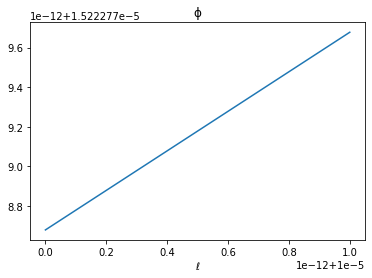

In [72]:
V_list = list()
for ℓ_i in ℓ_list:
    V_list.append(V_dict[ℓ_i][12, -1]/9000 )
plt.plot(ℓ_list,  np.array(V_list)+ℓ_list )
# plt.plot(ℓ_list, -ℓ_list)
plt.xlabel('ℓ')
plt.title('ϕ')

$$
 V( \ell)  = \min_{\ell \geqslant 0} \tilde V(\ell) + \ell r
$$

$$
 - \frac{\partial V}{\partial \ell} (\ell) = r
$$

Text(0.5, 0, 'y')

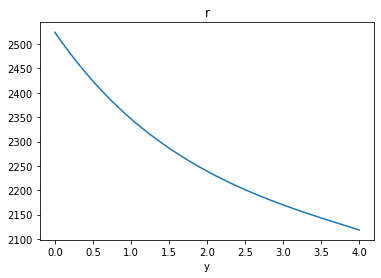

In [77]:
plt.plot(y_mat[:,0], - (V_dict[ℓ_list[1]][:,-1] - V_dict[ℓ_list[0]][:,-1])/ℓ_step/θ)
plt.title('r')
plt.xlabel('y')
# plt.savefig("r.png", dpi=148, facecolor='w', edgecolor='w',
#         orientation='portrait', format=None,
#         transparent=False, bbox_inches="tight", pad_inches=0.1,)

Text(0.5, 0, 'y')

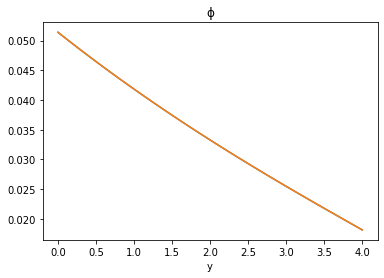

In [70]:
# plt.plot(y_mat[:,0], V_dict[0][:,-1])
plt.plot(y_mat[:,0], V_dict[ℓ][:,-1])
plt.plot(y_mat[:,0], V_dict[ℓ+ℓ_step][:,-1])
plt.title('ϕ')
plt.xlabel('y')

In [ ]:
episode = 0
lhs_error = 1
ems = - δ*η/(b_mat*(η-1)*dΛ*θ)
ems_old = ems
while lhs_error > tol:
    if episode ==0:
        v0 =  - δ*η*y_mat**2
    else:
        vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,hy)
    v0_dyy = derivatives_2d(v0,0,2,hy)
    v0_db = derivatives_2d(v0,1,1,hb)
    # updating controls

    print(np.min(ems))
    temp = v0_dy + b_mat*(η-1)*dΛ
    a = v0_dyy*σy**2 - temp**2/(b_mat*ξₘ)*σy**2+ b_mat*(η - 1)*ddΛ*σy**2
    b = temp*θ  - ℓ_i*θ 
    c = δ*η*b_mat
    Δ = b**2 - 4*c*a
    Δ[Δ<0] = 0
    ems_new =  -b/(2*a) - np.sqrt(Δ)/(2*a)
    ems_new[ems_new <= 0] = 1e-15
    ems = ems_new
    # HJB coefficient
    A =  np.zeros(y_mat.shape)
    B_y =  ems*θ
    B_b = - δ*b_mat
    C_yy = ems**2*σy**2/2
    C_bb = np.zeros(y_mat.shape)
    D = b_mat*δ*η*np.log(ems) +  b_mat*(η-1)*(dΛ*ems*θ + 1/2*ddΛ*ems**2*σy**2)\
    - ℓ_i*ems*θ - temp**2*ems**2*σy**2/(2*b_mat*ξₘ)
    # PDE solver
    solve_start = time.time()
    out = PDESolver_2d(stateSpace, A, B_y, B_b, C_yy, C_bb, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_b*v0_db + C_yy*v0_dyy + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems_old = ems
    print("End of PDE solver, takes time: {}".format(time.time() - solve_start))